# 设置参数

开头的参数准备很关键，作为后续整理的部分

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import scipy.io
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd

# # # # # # # #  set parameters  # # # # # # #  
    
CO2eff=5.35 #6.3 # W/m2 of 2*CO2

mat=1.8e20 # number of moles in the atm
rho_a=1e6/mat/12*1e15 #conversion factor from Pg (or Gt) to ppm

lamb=   1/ 0.8 # 3.8/4    #Climate feedback parameters(Wm-2/ K)


deltaT = 3.156e7  # seconds in a yearaddtionalforcing
H = 997 * 4187 * 300  # heat capacity of global ocean (300 m in depth)

# note that #H/deltaT-kappa_l = ~40
kappa_l=   20  # Land surface heat capacity (Wm-2)/(K/yr), note that the unit is convert to yr, not sec
kappa_o=  20  # H/deltaT-kappa_l # Ocean surface heat capacity 

Do=0.4 # heat diffusion coefficient from atm to ocean
# I change this from kdeep to Do, the table is wrong

# the following are related to carbon cycle

c_amp=1.1 #carbon feedback amplification factor

beta_l= 0.25 #Biosphere carbon fertilization parameter (Pg/ppm)
beta_o=  0.2  #Ocean carbon diffusion parameter(Pg/ppm)
beta_od=0.25 #Deep shallow ocean carbon diffusion coefficient(Pg/ppm)


gamma_l=  -0.13 #Biosphere temperature response(Pg/K)
gamma_o=  -0.2 #Ocean carbon solubility response(Pg/K)



aco2c = 280  # atmospheric co2 concentration in ppm
cina = aco2c/rho_a  # carbon in atm ; ppm -> Pg

oco2c = aco2c  # the ocean is in balance with atm
cino = 100     # the carbon stock in ocean; this is an assumption to be verfied
rho_o=oco2c/cino  #  rho is to convert Pg to ppm

odco2c = aco2c # the deep ocean is in balance with atm 
cinod = 1000 # the carbon stock in ocean; this is an assumption to be verified
rho_od= odco2c/cinod



# 设置年份的时间关键
model_init_year = 1850  
model_end_year = 2100  

time = np.array(range(model_init_year,model_end_year+1), dtype=int)  # 1850 to 2101

# in our model
# "future" starts from 2016. 
# "historical" ends in 2015.

print(time)


[1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861 1862 1863
 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877
 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891
 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905
 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919
 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947
 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961
 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975
 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989
 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031
 2032 2033 2034 2035 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045
 2046 

In [2]:
#line means the row that you want to extract data from
#left means the start column of the time 
#right means the end column of the time + 1
# 暂时还没有进行相关的调用

# 这个函数主要用于处理时间序列数据，使其具有均匀的时间间隔，以便进行后续的分析和处理。

def time_convert(df,line,left,right): 
    # iloc integer location,进行相关的定位
    row = df.iloc[line,left:right] #the row that you want to extract the data from
    time = row.index #the year corresponds to each data
    result = [] #the value corresponds to each year
    year = []
    count = 0

    for index in range(len(row)-1):
        curr = time[index] 
        next_one = time[index+1]
        result.append(row[curr])
        year.append(curr)
        diff = next_one - curr #find the difference between consecutive year in the table
        for i in range(1,diff):
            year.append(curr+i)
            result.append((row[next_one]-row[curr])*i/diff+row[curr]) #apply the formula 
    result.append(row[time[-1]]) #add the last value
    year.append(time[-1]) #add the last year
    final = pd.Series(result,index = year)
    return np.array(result)
        

简单的读取能量程序

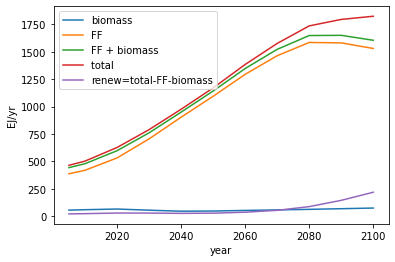

In [3]:
# read  energy

IAM_data = pd.read_excel('../data/input/energy_data11.12_TV.xlsx',sheet_name= 'future data')

# 可能是转换不同的行列内容操作
energy_baseline20052100_biomass= time_convert(IAM_data,12-2,5,16)
# should stick to total biomass, including the biomass burning power plants, not to switch to Primary Energy|Biomass|Traditional, 

energy_baseline20052100_FF = time_convert(IAM_data,6-2,5,16)
energy_baseline20052100_total= time_convert(IAM_data,18-2,5,16)

# 单独计算了
energy_baseline20052100_renew=energy_baseline20052100_total-energy_baseline20052100_FF-energy_baseline20052100_biomass

plt.plot(range(2005,2101),energy_baseline20052100_biomass,label = 'biomass')
plt.plot(range(2005,2101),energy_baseline20052100_FF,label = 'FF')
plt.plot(range(2005,2101),energy_baseline20052100_FF+energy_baseline20052100_biomass,label = 'FF + biomass')
plt.plot(range(2005,2101),energy_baseline20052100_total,label = 'total ')
plt.plot(range(2005,2101),energy_baseline20052100_renew,label = 'renew=total-FF-biomass')

plt.xlabel('year')
plt.ylabel('EJ/yr')
plt.legend()

相关Co2 数据的收支对应

In [4]:
# read CO2 baseline emission (1850-2100)


# 1850-2019: Global Carbon Budget (https://www.icos-cp.eu/GCP/2018)
# 2020-2100: IAM for CMIP6 
# we also seperate land use (LU) CO2 emission; total = FF+ LU

#need to read from sheet 1 of Global_Carbon_Budget_2018v1.0 for 1850-2019 (2018 to 2019 is manually added)
Global_Carbon_Budget = pd.read_excel('../data/input//Global_Carbon_Budget_2018v1.0.xlsx',sheet_name = 'Sheet1')

# 读取的某段时间的内容操作
CO2emission_baseline18502020_FF=np.array(Global_Carbon_Budget['FF_C'])
CO2emission_baseline18502020_LU=np.array(Global_Carbon_Budget['Land Use_C'])
CO2emission_baseline18502020=CO2emission_baseline18502020_FF+CO2emission_baseline18502020_LU # 直接进行相关的添加


#need to read from sheet 'data' of iamc_db for 2020-2100 (ignoring 2005 and 2010)
IAM_data = pd.read_excel('../data/input/energy_data11.12_TV.xlsx',sheet_name= 'future data')

# 时间单位上的相关转换
CO2emission_baseline20202100_FF = time_convert(IAM_data,37-2,7,16)*12/44/1000 # 时间的相关转换内容
CO2emission_baseline20202100_LU = time_convert(IAM_data,38-2,7,16)*12/44/1000

CO2emission_baseline18502100_FF =  np.concatenate((CO2emission_baseline18502020_FF,CO2emission_baseline20202100_FF)) # TODO 可能是相关拼接 
CO2emission_baseline18502100_LU =  np.concatenate((CO2emission_baseline18502020_LU,CO2emission_baseline20202100_LU))

CO2emission_baseline18502100=CO2emission_baseline18502100_FF+CO2emission_baseline18502100_LU

print(CO2emission_baseline20202100_FF)

[10.84436236 11.14400915 11.44365595 11.74330274 12.04294953 12.34259632
 12.64224311 12.9418899  13.24153669 13.54118348 13.84083027 14.23874624
 14.6366622  15.03457816 15.43249413 15.83041009 16.22832605 16.62624202
 17.02415798 17.42207395 17.81998991 18.25376997 18.68755004 19.1213301
 19.55511016 19.98889023 20.42267029 20.85645035 21.29023042 21.72401048
 22.15779055 22.67471722 23.19164389 23.70857056 24.22549724 24.74242391
 25.25935058 25.77627725 26.29320393 26.8101306  27.32705727 27.78622009
 28.24538291 28.70454573 29.16370855 29.62287136 30.08203418 30.541197
 31.00035982 31.45952264 31.91868545 32.26667746 32.61466947 32.96266148
 33.31065349 33.6586455  34.00663751 34.35462952 34.70262153 35.05061354
 35.39860555 35.43342518 35.46824482 35.50306445 35.53788409 35.57270373
 35.60752336 35.642343   35.67716264 35.71198227 35.74680191 35.658057
 35.56931209 35.48056718 35.39182227 35.30307736 35.21433245 35.12558755
 35.03684264 34.94809773 34.85935282]


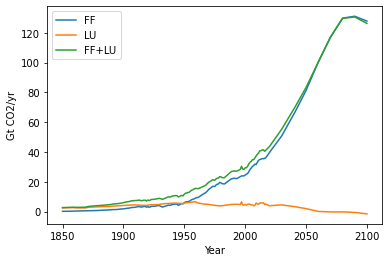

In [5]:
plt.plot(time,CO2emission_baseline18502100_FF*44/12,label = 'FF')
plt.plot(time,CO2emission_baseline18502100_LU*44/12,label = 'LU')
plt.plot(time,CO2emission_baseline18502100*44/12,label = 'FF+LU')
plt.xlabel('Year')
plt.ylabel('Gt CO2/yr')
plt.legend()

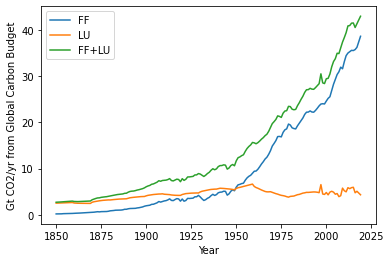

In [6]:
plt.plot(time[0:2020-1850],CO2emission_baseline18502020_FF*44/12,label = 'FF')
plt.plot(time[0:2020-1850],CO2emission_baseline18502020_LU*44/12,label = 'LU')
plt.plot(time[0:2020-1850],CO2emission_baseline18502020*44/12,label = 'FF+LU')
plt.xlabel('Year')
plt.ylabel('Gt CO2/yr from Global Carbon Budget')
plt.legend()

估计进行相关的转换内容

77.94219469397521
71.96499007373795
0.076687661204635


(2030.0, 2100.0)

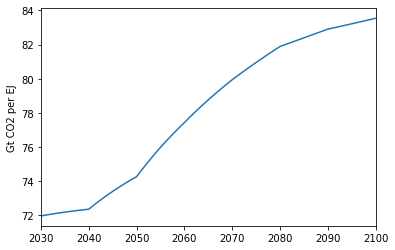

In [7]:

# convert energy to CO2 emission
# need to get a better estimate later considering the fuel types (oil, gas, coal)

# 利用的是最前面得到的相关数据部分
conversionfactor_FF_low = np.min(CO2emission_baseline18502100_FF[2005-model_init_year:2101-model_init_year]/energy_baseline20052100_FF)
conversionfactor_FF_high = np.mean(CO2emission_baseline18502100_FF[2006-model_init_year:2015-model_init_year]/energy_baseline20052100_FF[2006-2005:2015-2005])
print(conversionfactor_FF_high*44/12*1000)
print(conversionfactor_FF_low*44/12*1000)
print(1-conversionfactor_FF_low/conversionfactor_FF_high)

x=CO2emission_baseline18502100_FF[2005-model_init_year:2101-model_init_year]/energy_baseline20052100_FF
plt.plot(range(2005,2101), x*44/12*1000)
plt.ylabel('Gt CO2 per EJ')
plt.xlim((2030,2100))



#### 重新转换相关的数据

还是利用之前基础的相关数据

[ 387.4   393.74  400.08  406.42  412.76  419.1   430.35  441.6   452.85
  464.1   475.35  486.6   497.85  509.1   520.35  531.6   548.96  566.32
  583.68  601.04  618.4   635.76  653.12  670.48  687.84  705.2   724.98
  744.76  764.54  784.32  804.1   823.88  843.66  863.44  883.22  903.
  922.1   941.2   960.3   979.4   998.5  1017.6  1036.7  1055.8  1074.9
 1094.   1114.   1134.   1154.   1174.   1194.   1214.   1234.   1254.
 1274.   1294.   1311.   1328.   1345.   1362.   1379.   1396.   1413.
 1430.   1447.   1464.   1476.1  1488.2  1500.3  1512.4  1524.5  1536.6
 1548.7  1560.8  1572.9  1585.   1584.6  1584.2  1583.8  1583.4  1583.
 1582.6  1582.2  1581.8  1581.4  1581.   1575.9  1570.8  1565.7  1560.6
 1555.5  1550.4  1545.3  1540.2  1535.1  1530.  ]
26.509999999999977
2.5023633431574264
0.027343285074616325
0.12186345928016978
[   2.54034417    2.54034417    2.6814744     2.77556122    3.24599533
    3.34008215    3.5752992     3.62234261    3.66938603    3.90460308
    4.2809

(0.0, 2000.0)

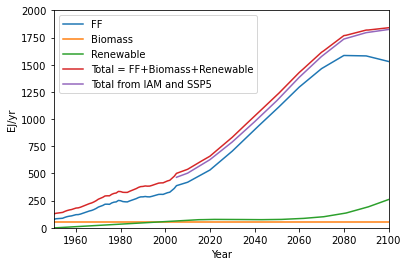

In [8]:
# KEY: reconstruct to get MY energy for 1850-2100


# FF (prior to 2005, assuming constant conversrion factor)
energy_MYbaseline18502004_FF = CO2emission_baseline18502100_FF[1850-model_init_year:2005-model_init_year]/conversionfactor_FF_high
# this is to get 'historical energy' since IAMs do not provide them

print(energy_baseline20052100_FF)
# 两个日期拼接完整的结果
energy_MYbaseline18502100_FF = np.concatenate((energy_MYbaseline18502004_FF, energy_baseline20052100_FF))  #*0.95
# NOTE: this is not directly used in the model

# Biomass (assuming a constant as in the 2015) and adjusted to make E12 8% of the total at 2016 (by multiplying it with 80%)
energy_MYbaselinePresent_biomass  = energy_baseline20052100_biomass[2015-2005]*0.8
energy_MYbaseline18502004_biomass =  np.ones(2004-1850+1)* energy_MYbaselinePresent_biomass
energy_MYbaseline20052100_biomass =  np.ones(2100-2005+1)* energy_MYbaselinePresent_biomass

# TODO 模拟相关的数值
energy_MYbaseline18502100_biomass = np.concatenate((energy_MYbaseline18502004_biomass, energy_MYbaseline20052100_biomass))
# NOTE: energy_MYbaseline18502100_biomass[0] is indirectly used later in the model

# Renewable (1950 to 2015, assuming linear growth)
# adjusted to make renewlable 12% of the total at 2016 (by adding a constant of 48 to it)

energy_MYbaseline18501950_renew =  np.ones(1950-1850+1)*0 
energy_MYbaseline19512015_renew= np.linspace(0,energy_baseline20052100_renew[10]+48,num= 2015-1951+1)
energy_MYbaseline20162100_renew= energy_baseline20052100_renew[10:-1]+48

energy_MYbaseline18502100_renew = np.concatenate((energy_MYbaseline18501950_renew, energy_MYbaseline19512015_renew, energy_MYbaseline20162100_renew))

print(energy_baseline20052100_renew[10])
# NOTE: this is not used in the model




# ############## Total energy = FF+biomass+Renew
energy_MYbaseline18502100_total = energy_MYbaseline18502100_renew+energy_MYbaseline18502100_biomass+energy_MYbaseline18502100_FF
# NOTE: this is the only major input used in the model



# 大部分都是进行相关显示绘制的数据

plt.plot(time,energy_MYbaseline18502100_FF,label = 'FF')
plt.plot(time,energy_MYbaseline18502100_biomass,label = 'Biomass')
plt.plot(time,energy_MYbaseline18502100_renew,label = 'Renewable')
plt.plot(time,energy_MYbaseline18502100_total,label = 'Total = FF+Biomass+Renewable')
plt.plot(range(2005,2101),energy_baseline20052100_total,label = 'Total from IAM and SSP5  ')

print(energy_MYbaseline18502100_FF[2100-model_init_year]/energy_MYbaseline18502100_total[2016-model_init_year])   # coming from SSP5 for future as well as indirectly inferred from CO2 emission for the past
print(energy_MYbaseline18502100_biomass[2100-model_init_year]/energy_MYbaseline18502100_total[2100-model_init_year])  # this is indirectly used in the model
print(energy_MYbaseline18502100_renew[2016-model_init_year]/energy_MYbaseline18502100_total[2016-model_init_year])    #  this is indirectly used in the model with the fraction
# these fractions, agree with REN(2018) by manunuall adjusting

print(energy_MYbaseline18502100_FF)
plt.xlabel('Year')
plt.ylabel('EJ/yr')
plt.legend()
plt.xlim((1950,2100))
plt.ylim((0,2000))

## GDP 外部输入的关键部分

(1950.0, 2100.0)

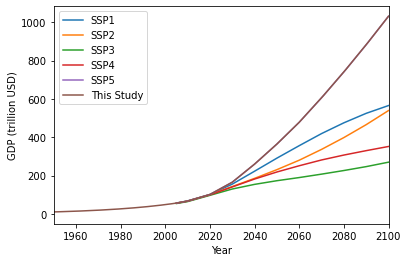

In [9]:
GDP = pd.read_excel('../data/input/PopulationGDP_9.12.19.xlsx',sheet_name= 'GDP Projection Scenarios')

# 分别进行相关绘制操作
for i in range(1,6):
    plt.plot(GDP.iloc[:,0],GDP.iloc[:,i],label = '{}'.format(GDP.columns[i]))


    
GDP_formulated=57*1e12*np.exp(0.03*((time)-2005))
# historical extraploation can be compared to 
#https://tntcat.iiasa.ac.at/SspDb/dsd?Action=htmlpage&page=30

GDP_formulated[2005-1850:2101-1850]=GDP.iloc[:,5]*1e12



plt.plot(time, GDP_formulated/1e12, label = 'This Study')

plt.xlabel('Year')
plt.ylabel('GDP (trillion USD)')
plt.legend() 
plt.xlim((1950,2100))
#plt.ylim((0,150))


Text(0, 0.5, 'Energy intensity (EJ/TrillionUSD)')

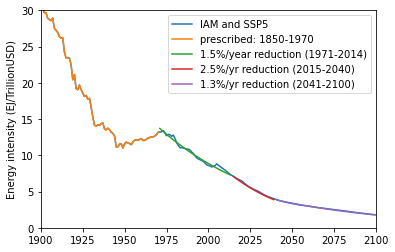

In [10]:
#for i in range(5,6):
 #   plt.plot(GDP.iloc[:,0],GDP.iloc[:,i],label = '{}'.format(GDP.columns[i]))

plt.plot(time, energy_MYbaseline18502100_total/GDP_formulated*1e12, label = 'IAM and SSP5')




EnergyEfficiency_formulated18501970=energy_MYbaseline18502100_total[1850-1850:1971-1850]/GDP_formulated[1850-1850:1971-1850]*1e12
plt.plot(time[1850-1850:1971-1850], EnergyEfficiency_formulated18501970[1850-1850:1971-1850], label = 'prescribed: 1850-1970')

EnergyEfficiency_formulated19712014=energy_MYbaseline18502100_total
EnergyEfficiency_formulated19712014=energy_MYbaseline18502100_total[2015-1850]/GDP_formulated[2015-1850]*1e12*np.exp(-0.015*((time)-2015))
plt.plot(time[1971-1850:2014-1850], EnergyEfficiency_formulated19712014[1971-1850:2014-1850], label = '1.5%/year reduction (1971-2014)')

EnergyEfficiency_formulated20152040=energy_MYbaseline18502100_total
EnergyEfficiency_formulated20152040=energy_MYbaseline18502100_total[2015-1850]/GDP_formulated[2015-1850]*1e12*np.exp(-0.025*((time)-2015))
plt.plot(time[2015-1850:2040-1850], EnergyEfficiency_formulated20152040[2015-1850:2040-1850], label = '2.5%/yr reduction (2015-2040)')

EnergyEfficiency_formulated20412100=energy_MYbaseline18502100_total
EnergyEfficiency_formulated20412100=energy_MYbaseline18502100_total[2041-1850]/GDP_formulated[2041-1850]*1e12*np.exp(-0.013*((time)-2040))
plt.plot(time[2041-1850:2100-1850], EnergyEfficiency_formulated20412100[2041-1850:2100-1850], label = '1.3%/yr reduction (2041-2100)')


plt.xlim([1900, 2100])
plt.ylim([0, 30])
plt.legend() 
plt.ylabel('Energy intensity (EJ/TrillionUSD)')

251
251


Text(0.5, 0, 'Year')

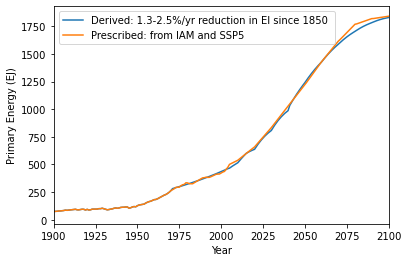

In [11]:





EnergyEfficiency_formulated18502100=  np.concatenate((EnergyEfficiency_formulated18501970[1850-1850:1971-1850], EnergyEfficiency_formulated19712014[1971-1850:2014-1850+1], EnergyEfficiency_formulated20152040[2015-1850:2040-1850+1], EnergyEfficiency_formulated20412100[2041-1850:2100-1850+1]))

print(len(EnergyEfficiency_formulated18502100))
      
print(len(GDP_formulated))

energy_MYbaseline18502100_total_formulated=EnergyEfficiency_formulated18502100*GDP_formulated/1e12


                                                                                
                                                                                
plt.plot(time, energy_MYbaseline18502100_total_formulated, label = 'Derived: 1.3-2.5%/yr reduction in EI since 1850 ')

plt.plot(time, energy_MYbaseline18502100_total, label = 'Prescribed: from IAM and SSP5')



plt.xlim([1900, 2100])
#plt.ylim([0, 700])
plt.legend() 
plt.ylabel('Primary Energy (EJ)')
plt.xlabel('Year')
                                                                                
                                                                                

### 添加历史的非 Co2 强迫数据

In [12]:
# reading in historical (1800-2005) non CO2 forcing

mat2 = scipy.io.loadmat('../data/input/forcing20th_normal_SLR2012.mat')
# this is the output from my 2017 modeling
# copied from /Users/yangyang/YANGYANGXU/work/PNAS2017/model2017/1Forcing/20thcentury_aerosolrange
 
FC_HC_hist= mat2['toexport_HC'][0]   
FC_CH4_hist= mat2['toexport_CH4'][0]   
FC_N2O_hist= mat2['toexport_N2O'][0] 
FC_COO3_hist= mat2['toexport_restGHG'][0]   
FC_aerosol_hist= mat2['FC_aerosol'][0]   

FC_solar_hist= mat2['FC_solar'][0] 
FC_land_hist= mat2['FC_land'][0]   
#FC_CO2= mat2['toexport_CO2'][0]   


# 评估得到的总值
FC_GHG_nonCO2_hist=FC_HC_hist+FC_CH4_hist+FC_N2O_hist+FC_COO3_hist #GHGs forcing compared to pre-industry

aerosolforcing19002005=FC_aerosol_hist
nonCO2GHGforcing19002005=FC_GHG_nonCO2_hist +FC_land_hist+FC_solar_hist

print(aerosolforcing19002005[-1])
print(FC_aerosol_hist[-1])
#print(time)
#nonCO2forcing19002005=FC_GHG_nonCO2+FC_aerosol;
#plt.plot( nonCO2forcing19002005, 'b', label='CO2emission_baseline')


-1.2000002
-1.2000002


#### non-Co2 forcing 数据

可能其中一部分数据来源于其他模拟得到，分时间阶段

In [13]:
  ### ##   add non-CO2 forcing  ######
    
# reading in future (2006-2100) forcing

mat1 = scipy.io.loadmat('../data/input/newforcing_SLR2012_RCP85RXMhybrid_Paris2015_95p5p.mat')
# this is the output from my 2017 modeling


# copied from /Users/yangyang/YANGYANGXU/work/PNAS2017/model2017/1Forcing/SLR2012_RCPandRXM
    
# these are all relative to 2005
FC_N2O= mat1['FC_N2O'][0] 

FC_HC_BAU= mat1['FC_HC_BAU'][0] 
FC_HC_MIT= mat1['FC_HC_MIT'][0]   

FC_BC_BAU= mat1['FC_BC_BAU'][0]
FC_BC_MIT= mat1['FC_BC_MIT'][0] 

FC_OC_BAU= mat1['FC_OC_BAU'][0]   
FC_OC_MIT= mat1['FC_OC_MIT'][0]  

#FC_CH4_BAU= mat1['FC_CH4_BAU'][0]
#FC_CH4_MIT= mat1['FC_CH4_MIT'][0]   

FC_COO3_BAU= mat1['FC_CO_BAU'][0]
FC_COO3_MIT= mat1['FC_CO_MIT'][0]   

FC_SO4_BAU= mat1['FC_SO4_BAU'][0]
FC_SO4_MIT= mat1['FC_SO4_MIT'][0] 

#FC_indirect_SO2MIT= mat1['FC_indirect_SO2MIT'][0]   
#FC_indirect_allBAU= mat1['FC_indirect_allBAU'][0]   
#FC_indirect_allMIT= mat1['FC_indirect_allMIT'][0]   
# scale this into SO2 and OC by multiplying eachh withh 2


# continue here on Wed
#to settle on the strengt of te coupling, 
#try one SLCP at a time
#confirm the base forcing at 2005 to ensure continuity
#resolve ch4 forcing, maybe try a smart way factor in the lag and sqr root



CO2emission_actualFF2005=8

BC_cpl_share=0.25   
OC_cpl_share=0

SO2_cpl_share=0   # !!!do not couple SO2 with FF, because it's doomed to go down in all scenarios even in BAU
#E_CH4_BA
CH4_cpl_share= 0.4 
COO3_cpl_share=0.4

BCforcing2005=0.9
OCforcing2005=-0.4-0.4  # including indirect

SO2forcing2005=-0.4-0.4  # including NOx and including indirect

CH4forcing2005=0.57+0.07+0.016+0.2
COO3forcing2005=0.21  #  

NOxforcing2005=-0.5 # its mitigation was not considered in future simulations, to be included in PNSA2021    
FC_NOx_BAU= NOxforcing2005/SO2forcing2005*FC_SO4_BAU
FC_NOx_MIT= NOxforcing2005/SO2forcing2005*FC_SO4_MIT

 

#### 从排放中模拟 CH4 

In [14]:
# CH4 modeling from emission, instead of just reading in forcing

baseline_CH4_PI=715  # ppb in pre-industry
baseline_CH4_2005 = 1774 # ppb at 2005
tau_CH4=12
t0=2005 # year 0 is 2005

# BAU
Emission_CH4_BAU= mat1['E_CH4_BAU'][0]
# MIT
Emission_CH4_MIT= mat1['E_CH4_MIT'][0]

# non coupling
E_CH4natural=100; 
E_CH4anth=Emission_CH4_BAU-E_CH4natural; # Mt from Cofala 2006  ## do not mess with this line !!!!
E_CH4anth_FF=E_CH4anth*CH4_cpl_share
E_CH4anth_nonFF=E_CH4anth*(1-CH4_cpl_share)
Emission_CH4_coupling=E_CH4anth_FF
Emission_CH4_nocoupling=E_CH4anth_nonFF+E_CH4natural

# add only whhen do force dedicated CH4 mitgaiton while with zerol share coupling
# add only whhen do force dedicated CH4 mitgaiton while with zerol share coupling
# add only whhen do force dedicated CH4 mitgaiton while with zerol share coupling
# add only whhen do force dedicated CH4 mitgaiton while with zerol share coupling
# add only whhen do force dedicated CH4 mitgaiton while with zerol share coupling
#Emission_CH4_nocoupling=Emission_CH4_MIT

print(Emission_CH4_MIT)
print(Emission_CH4_BAU)

# select which emission to use
Emission_CH4=Emission_CH4_BAU

# start of CH4 model
vc=[0] # concentration increase since 2005 vc[0]=2005
decay=[0] # concentration decrease due to 2005 concentrationd decay
for i in range(1, 96): # the year on which the concentration increase needs to be calculated, starting from 2006 (Year 1), and ending in 2100 ( year 95)
    #print(Emission_CH4_BAU[0:i]/2.78) # convert Mt CH4 to ppb
    #print(time[0:i]-1850) 
    # i-(time[0:i]-1850) is thhe time lapse from previous years to this year
    #print(np.exp(-(i-(time[0:i]-1850))/tau_CH4 )) # year 0 is 2005
    #print((Emission_CH4_BAU[0:i]/2.78*np.exp(-(i-(time[0:i]-1850))/tau_CH4 ))) # year 0 is 2005
    vc.append(np.cumsum(Emission_CH4[0:i]/2.78*np.exp(-(i-(time[0:i]-1850)-1)/tau_CH4 ))[-1]) # add -1 so that the decay is slower
    #print(vc[-1]) # year 0 is 2005
    decay.append(baseline_CH4_2005*((1-np.exp(-(time[i]-1850 )/tau_CH4)))) 
    #print(vc[-1]+decay[-1]);

    
CH4_concentration= [baseline_CH4_2005+a-b for a, b in zip (vc,decay)]

DF= [0.57*(a**.5-baseline_CH4_PI**.5)/(baseline_CH4_2005**.5-baseline_CH4_PI**.5) for a in CH4_concentration]
IDF1=[0.07*(a-baseline_CH4_PI)/(baseline_CH4_2005-baseline_CH4_PI) for a in CH4_concentration]
IDF2=[0.016*(a-baseline_CH4_PI)/(baseline_CH4_2005-baseline_CH4_PI) for a in CH4_concentration]
IDF3=[0.2*(a-baseline_CH4_PI)/(baseline_CH4_2005-baseline_CH4_PI) for a in CH4_concentration]

FC_CH4 = [a+b+c+d-(0.57+0.07+0.016+0.2) for a,b,c,d in zip(DF,IDF1,IDF2,IDF3)]   
# end of CH4 model
# save the forcing for later use
FC_CH4_BAU = FC_CH4






#print([a-b for a, b in zip (vc,decay)])

# select which emission to use
Emission_CH4=Emission_CH4_MIT
# start of CH4 model
vc=[0] # concentration increase since 2005 vc[0]=2005
decay=[0] # concentration decrease due to 2005 concentrationd decay
for i in range(1, 96): # the year on which the concentration increase needs to be calculated, starting from 2006 (Year 1), and ending in 2100 ( year 95)
    #print(Emission_CH4_BAU[0:i]/2.78) # convert Mt CH4 to ppb
    #print(time[0:i]-1850) 
    # i-(time[0:i]-1850) is thhe time lapse from previous years to this year
    #print(np.exp(-(i-(time[0:i]-1850))/tau_CH4 )) # year 0 is 2005
    #print((Emission_CH4_BAU[0:i]/2.78*np.exp(-(i-(time[0:i]-1850))/tau_CH4 ))) # year 0 is 2005
    vc.append(np.cumsum(Emission_CH4[0:i]/2.78*np.exp(-(i-(time[0:i]-1850)-1)/tau_CH4 ))[-1])
    #print(vc[-1]) # year 0 is 2005
    decay.append(baseline_CH4_2005*((1-np.exp(-(time[i]-1850)/tau_CH4))))
    #print(decay[-1]);
CH4_concentration= [baseline_CH4_2005+a-b for a, b in zip (vc,decay)]
DF= [0.57*(a**.5-baseline_CH4_PI**.5)/(baseline_CH4_2005**.5-baseline_CH4_PI**.5) for a in CH4_concentration]
IDF1=[0.07*(a-baseline_CH4_PI)/(baseline_CH4_2005-baseline_CH4_PI) for a in CH4_concentration]
IDF2=[0.016*(a-baseline_CH4_PI)/(baseline_CH4_2005-baseline_CH4_PI) for a in CH4_concentration]
IDF3=[0.2*(a-baseline_CH4_PI)/(baseline_CH4_2005-baseline_CH4_PI) for a in CH4_concentration]
FC_CH4 = [a+b+c+d-(0.57+0.07+0.016+0.2) for a,b,c,d in zip(DF,IDF1,IDF2,IDF3)]   
# end of CH4 model
# save the forcing for later use
FC_CH4_MIT = FC_CH4


len(CH4_concentration)
baseline_CH4_2015=CH4_concentration[2015-2005]

[394.35       398.5106     402.73028052 407.0098805  411.35025081
 415.75225437 420.21676638 424.74467446 429.33687884 433.99429252
 438.71784147 443.50846482 448.36711502 453.29475806 458.29237362
 463.36095533 458.22039976 453.15284008 448.15723975 443.23257695
 438.37784436 433.59204897 428.87421187 424.22336806 419.63856624
 415.1188686  410.66335066 406.27110108 401.94122145 397.6728261
 393.46504197 389.31700838 385.22787686 381.19681101 377.22298629
 373.30558988 369.44382051 365.63688826 361.88401444 358.18443144
 354.53738251 350.94212168 347.39791355 343.90403318 340.45976591
 337.06440723 337.06440723 337.06440723 337.06440723 337.06440723
 337.06440723 337.06440723 337.06440723 337.06440723 337.06440723
 337.06440723 337.06440723 337.06440723 337.06440723 337.06440723
 337.06440723 337.06440723 337.06440723 337.06440723 337.06440723
 337.06440723 337.06440723 337.06440723 337.06440723 337.06440723
 337.06440723 337.06440723 337.06440723 337.06440723 337.06440723
 337.064407

#### 绘图

比较不同的减排情景下的对应操作

Text(0, 0.5, 'forcing (W/m2)')

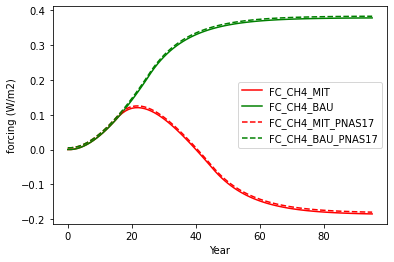

In [15]:
   
plt.plot( FC_CH4_MIT, 'r', label='FC_CH4_MIT')
plt.plot( FC_CH4_BAU, 'g', label='FC_CH4_BAU')

FC_CH4_BAU_PNAS17= mat1['FC_CH4_BAU'][0]
FC_CH4_MIT_PNAS17= mat1['FC_CH4_MIT'][0]

plt.plot( FC_CH4_MIT_PNAS17+0.005, 'r--', label='FC_CH4_MIT_PNAS17')
plt.plot( FC_CH4_BAU_PNAS17+0.005, 'g--', label='FC_CH4_BAU_PNAS17')

#plt.xlim([1850, 2098])
plt.legend()
plt.xlabel('Year')
plt.ylabel('forcing (W/m2)') 
   

In [16]:
 # BAU of SLCP , not so4 and Oc
nonCO2GHGforcing20062100_BAU= FC_N2O  +FC_HC_BAU +  FC_CH4_BAU + FC_COO3_BAU + nonCO2GHGforcing19002005[-1]
aerosolforcing20062100_BAU= FC_BC_BAU+ FC_SO4_MIT*2+FC_OC_BAU*2 + aerosolforcing19002005[-1] +FC_NOx_MIT

# MIT of SLCP , not so4 and Oc
nonCO2GHGforcing20062100_MIT= FC_N2O  +FC_HC_MIT +  FC_CH4_MIT + FC_COO3_MIT + nonCO2GHGforcing19002005[-1]
aerosolforcing20062100_MIT= FC_BC_MIT+ FC_SO4_MIT*2 +FC_OC_MIT*2  + aerosolforcing19002005[-1]+FC_NOx_MIT

nonCO2GHGforcing18501899= np.zeros(1899-1850) # np.array(0, with a length of 1899-1850+1).
aerosolforcing18501899= np.zeros(1899-1850) # np.array(0, with a length of 1899-1850+1).

nonCO2GHGforcing18502100_BAU= np.concatenate((nonCO2GHGforcing18501899, nonCO2GHGforcing19002005,nonCO2GHGforcing20062100_BAU), axis=None)
aerosolforcing18502100_BAU= np.concatenate((aerosolforcing18501899, aerosolforcing19002005,aerosolforcing20062100_BAU), axis=None)

nonCO2GHGforcing18502100_MIT= np.concatenate((nonCO2GHGforcing18501899, nonCO2GHGforcing19002005,nonCO2GHGforcing20062100_MIT), axis=None)
aerosolforcing18502100_MIT= np.concatenate((aerosolforcing18501899, aerosolforcing19002005,aerosolforcing20062100_MIT), axis=None)




In [17]:


# for coupling, we need to calculate the part that is not coupled , 
# which can be BAU or MIT, depending on your goal

nonCO2GHGforcing20062100_nocoupling_noCH4= FC_N2O  +FC_HC_BAU +   FC_COO3_BAU*(1-COO3_cpl_share) +nonCO2GHGforcing19002005[-1]# +  FC_CH4_MIT
aerosolforcing20062100_nocoupling= FC_BC_BAU*(1-BC_cpl_share)+ FC_SO4_MIT*2*(1-SO2_cpl_share)+FC_OC_BAU*2*(1-OC_cpl_share) +aerosolforcing19002005[-1] +FC_NOx_MIT



nonCO2GHGforcing18502100_nocoupling_noCH4= np.concatenate((nonCO2GHGforcing18501899, nonCO2GHGforcing19002005,nonCO2GHGforcing20062100_nocoupling_noCH4), axis=None)
aerosolforcing18502100_nocoupling= np.concatenate((aerosolforcing18501899, aerosolforcing19002005,aerosolforcing20062100_nocoupling), axis=None)
    


Text(0, 0.5, 'forcing (W/m2)')

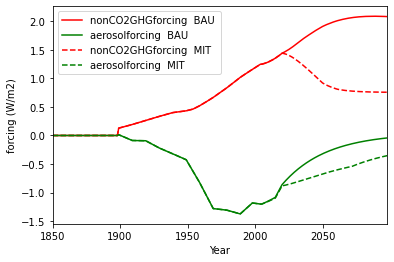

In [18]:
plt.plot( time,nonCO2GHGforcing18502100_BAU, 'r', label='nonCO2GHGforcing  BAU ')
plt.plot( time,aerosolforcing18502100_BAU, 'g', label='aerosolforcing  BAU')
plt.plot( time,nonCO2GHGforcing18502100_MIT, 'r--', label='nonCO2GHGforcing  MIT')
plt.plot( time,aerosolforcing18502100_MIT, 'g--', label='aerosolforcing  MIT')
#plt.plot( time,nonCO2GHGforcing18502100_nocoupling_noCH4, 'r-.', label='nonCO2GHGforcing  no coupling no CH4')
#plt.plot( time,aerosolforcing18502100_nocoupling, 'g-.', label='aerosolforcing  no coupling')

plt.xlim([1850, 2098])
plt.legend()
plt.xlabel('Year')
plt.ylabel('forcing (W/m2)')

In [19]:
#print(FC_CO2_BAU[2020-2005]+FC_CO2[-1])

print(CO2eff*np.log(405/rho_a/cina))

print(FC_N2O[2020-2005]+FC_N2O_hist[-1])

print(FC_HC_BAU[2020-2005]+FC_HC_hist[-1])

print(FC_BC_BAU[2020-2005]+BCforcing2005)
#print(FC_HFC_BAU[2020-2005]+BCforcing2005)

print(FC_CH4_BAU[2020-2005]+CH4forcing2005)
print(FC_COO3_BAU[2020-2005]+COO3forcing2005)


#print(FC_BC_BAU[2020-2005]+0.9)


#print(FC_CH4_BAU[2020-2005]+FC_CH4[-1])


#print(FC_COO3_BAU[2020-2005]+FC_COO3[-1])


1.9746714320644987
0.18266666666666667
0.368
1.1360202172221237
0.9416684999114979
0.2586953483727347


### 计算的前期准备

In [58]:
#from UliEngineering.SignalProcessing.Simulation import sine_wave
#data = sine_wave(frequency=1/60, amplitude=0.5,samplerate = 60)
#plt.plot(data)


    

import math
#amp =  np.random.normal(0.5, 0.1, 251) # *0 
#phase = np.random.uniform(0,60,1)[0]
#period = np.random.normal(50,10,26)

amp = np.random.normal(2, 0.1, 251)*0 
phase = np.random.uniform(0,60,1)[0]
period = np.random.normal(5,5,26)

# here as a place holder only, make the amplitude zero so tthhat no noise is used in the base case of the model
# see the last portion of this code to include random noise effect in the model, even with an ensemble

#### IEM formulation（IEM 程序）

注意对其单独书写进行处理

In [ ]:

 #### the IEM formulation 
# # # # # # #  prepare to output internal parameters as a time series  # # # # # #         
            
            
global taoR21,taoP21,taoDV21,taoDF21,tao21,taoR22,taoP22,taoDV22,taoDF22,tao22,time_count, CO2emission_GE_FF, CO2emission_addl_B3B_FF_injustice, CO2emission_addl_B3B_FF, CO2emission_actual, CO2emission_net, CO2emission_actualFF, CO2emission_actualbiomass, energy_MYadjusted18502100_total_plus_B3B,energy_MYadjusted18502100_total, energy_addl_B3B_EnhanceRatio,energy_addl_ACE3,energy_MYadjusted18502100_total_plus_B3B_plus_ACE3, eta21,eta22, CO2emission_addl_enhance

# 28 个量
k21, k22, taoR21 , taoP21 , taoDV21 , tao21,tao22,taoDF21 , taoR22 , taoP22 , taoDV22 , taoDF22 ,time_count,CO2emission_GE_FF, CO2emission_addl_B3B_FF_injustice,  CO2emission_addl_B3B_FF, CO2emission_actual ,CO2emission_net, CO2emission_actualFF, CO2emission_actualbiomass, energy_MYadjusted18502100_total_plus_B3B, energy_MYadjusted18502100_total, energy_addl_B3B_EnhanceRatio,energy_addl_ACE3,energy_MYadjusted18502100_total_plus_B3B_plus_ACE3,eta21, eta22, CO2emission_addl_enhance=[],[], [],[],[],[],[],[],[], [],[],[],[],[], [],[],[],[],[],[],[],[],[],[],[],[],[],[]

global CO2emission_ACE1, CO2emission_ACE2, CO2emission_ACE3,CO2emission_betaACE3, lamb_l,additional_forcing_l

# 7个量
CO2emission_ACE1, CO2emission_ACE2, CO2emission_ACE3,CO2emission_betaACE3,lamb_l,additional_forcing_l, ratio_net_over_gross= [],[],[],[],[],[],[]

# 5个量
global CO2emission_addl_ACE3_FF, CO2emission_addl_ACE3_FF_injustice, Emission_CH4_coupling_actual, Emission_CH4_actual,FC_CH4
CO2emission_addl_ACE3_FF, CO2emission_addl_ACE3_FF_injustice, Emission_CH4_coupling_actual,Emission_CH4_actual,FC_CH4 =[],[],[],[],[] 

def IEM(y, time):      #, kappa_l,Do,gamma_l,gamma_o,c_amp,rho_a,beta_l,beta_o,lamb,rho_o,rho_od,beta_od,kappa_o

    #added Oct 27 2021 for final revision
    energy_MYbaseline18502100_total=  energy_MYbaseline18502100_total_formulated 
    #is the only real data input to the model, not FF/biomass/renewable break up of energy
    #added Oct 27 2021 for final revision

        
    T_a,C_a,C_o,C_od,T_o, E21, E22, E23, E24, E12 = y

    #print(int(time))
    if int(time) not in time_count:
        
        if (T_a < 1):
            conversionfactor_FF=conversionfactor_FF_high
        elif (T_a < 2):
            conversionfactor_FF=conversionfactor_FF_high-(conversionfactor_FF_high-conversionfactor_FF_low)/1*(T_a-1)
        else:
            conversionfactor_FF=conversionfactor_FF_low
          
        # comment this out to make convertion factor a variable
        #converstionfactor_FF=conversionfactor_FF_high

     
            
        # the improment of energy intensity
        if (time<2015):
            re = 1
        else:
            re =   np.exp(-0.005*(1+T_a**1)*(time-2016))/np.exp(-0.005*(time-2016))
            #re =   np.exp(-0.005*(T_a**1)*(time-2016))
            #re =   np.exp(-0.005*(T_a-1))
            #re =1 # case 10, without energy efficienty
            if (re < 0.7):
                re = 0.7
            
               
           
            # approach 0; not considering the Bottom Trillions
            energy_addl_B3B_EnhanceRatio.append(float(0))
            
          
         
        

        
        # calculate the total energy demand, from the baseline
        # June 24, 2021, now using th formulated energy from GDP
        
        energy_MYadjusted18502100_total.append(energy_MYbaseline18502100_total[int(time)-model_init_year]*re) # accounting for re    # Oct 27, 2021; use energy_MYbaseline18502100_total_formulated  or energy_MYbaseline18502100_total
        
        energy_addl_B3B=energy_MYbaseline18502100_total[int(time)-model_init_year]*energy_addl_B3B_EnhanceRatio[-1]      # additional energy due to B3B
        
        energy_MYadjusted18502100_total_plus_B3B.append(energy_MYadjusted18502100_total[int(time)-model_init_year]+energy_addl_B3B)  # including B3B but not ACE3

        
   
    ### Aug 21 ACE   ###
    if int(time) not in time_count:

        ACE3_annualcap=20.0   # set to 20 or 50

        E11dummy=energy_MYadjusted18502100_total_plus_B3B[-1]- E12 - E21 - E22 - E23 - E24         # in this model set up, E terms are absoluate values
        
        if (E11dummy<0):
            E11dummy=0  # net/gross
            
        E11fractiondummy=E11dummy/energy_MYadjusted18502100_total_plus_B3B[-1]

        E11fraction_ACE3=E11fractiondummy  # YOU CAN change this 1 to assume ACE3 to use  FF only
        
        if (time<2020):
            ratio_net_over_gross.append(1)  # net/gross
        else:
            ratio_net_over_gross.append(1-10*E11fraction_ACE3*conversionfactor_FF*44/12)  # net/gross ratio
        
        
        if (time<2020):
            CO2emission_ACE1.append(0)  # net
            CO2emission_ACE2.append(0)
            CO2emission_ACE3.append(0)
            CO2emission_betaACE3.append(0)  # offset.  #(gross-offset=net)
            CO2emission_net.append(0)  # net

        else:
            taoACE1 = 10*np.exp(-1*(T_a-1.0))
            taoACE2 = 10*np.exp(-1*(T_a-1.5))
            taoACE3 = 10*np.exp(-1*(T_a-2.0))
            if (taoACE1 < 1):
                taoACE1 = 1
            if (taoACE2 < 1):
                taoACE2 = 1
            if (taoACE3 < 1):
                taoACE3 = 1
            
          
            gammarACE1= 1.0 
            gammarACE2= 1.0
            # cost is 500 USD per ton of carbon
            CPT=500/(1+2*CO2emission_ACE3[-1]*44/12)
            if (CPT < 50):
                CPT = 50
            gammarACE3= 1.0-CO2emission_ACE3[-1]*44/12*1e9*CPT/(0.005*T_a**2*(GDP_formulated[int(time)-model_init_year]))
            print(CO2emission_ACE3[-1]*44/12*1e9*CPT/(GDP_formulated[int(time)-model_init_year])*100)
            #print(1-gammarACE3)
            etaACE1=0.01-CO2emission_ACE1[-1]/taoACE1
            etaACE2=0.01-CO2emission_ACE2[-1]/taoACE2
            etaACE3=0.01-CO2emission_ACE3[-1]/ratio_net_over_gross[-1]/taoACE3
            if (etaACE1 < 0):
                etaACE1 = 0
            if (etaACE2 < 0):
                etaACE2 = 0
            if (etaACE3 < 0):
                etaACE3 = 0
            #print(etaACE3)   
            
            betaACE1= 0.0 # no energy input required
            betaACE2= 0.0
            
           

            betaACE3= CO2emission_ACE3[-1]/ratio_net_over_gross[-1]*10*E11fraction_ACE3*44/12*conversionfactor_FF/taoACE3  
            #converstion factor is 10 EJ/Gt of GROSS extraction
            
            
            
            
            CO2emission_ACE1.append(CO2emission_ACE1[-1]+(1.0-np.sum(CO2emission_ACE1[int(time)-2020:-1])/(500.0/(44/12))) * (1.0-np.sum(CO2emission_ACE1[-1])/(4.0/(44/12)))* gammarACE1*CO2emission_ACE1[-1]/taoACE1 + etaACE1 - betaACE1)
            CO2emission_ACE2.append(CO2emission_ACE2[-1]+(1.0-np.sum(CO2emission_ACE2[int(time)-2020:-1])/(500.0/(44/12))) * (1.0-np.sum(CO2emission_ACE2[-1])/(4.0/(44/12)))* gammarACE2*CO2emission_ACE2[-1]/taoACE2 + etaACE2 - betaACE2)
            CO2emission_ACE3.append(CO2emission_ACE3[-1]+(1.0-np.sum(CO2emission_ACE3[int(time)-2020:-1])/(5000/(44/12))) * (1.0-np.sum(CO2emission_ACE3[-1])/(ACE3_annualcap/(44/12)))* gammarACE3*(CO2emission_ACE3[-1]/ratio_net_over_gross[-1])/taoACE3 + etaACE3 - betaACE3)
            #CO2emission_ACE2.append(betaACE3)
            #print(betaACE3)
            
            #CO2emission_ACE1[-1]=0
            #CO2emission_ACE2[-1]=0
            #CO2emission_ACE3[-1]=0


            ### end of ACE ###      
        
       
    
    
    
    
    
    
    
        ################### second re definition of the real E11 ######################################
        
        energy_addl_ACE3.append(float(CO2emission_ACE3[-1])/ratio_net_over_gross[-1]*10.*44./12.)
        
        energy_addl_ACE3_FF=energy_addl_ACE3[-1]*E11fractiondummy # following the same fraction as in general economy
        energy_addl_ACE3_FF_injustice=energy_addl_ACE3[-1]*E11fraction_ACE3  # can allow a different fraction to account for climate injustice. with climate justice, this should be thhe same as above

        
        energy_MYadjusted18502100_total_plus_B3B_plus_ACE3.append(float(energy_MYadjusted18502100_total_plus_B3B[-1]+energy_addl_ACE3[-1]))
        
        E11=energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1]- E12 - E21 - E22 - E23 - E24         # in this model set up, E terms are absoluate values
                
        E11fraction=E11/energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1]
        E11fraction_B3B=E11fraction    #change this 1 to assume B3B to use only FF , under climate injustice
        
                
        energy_addl_B3B_FF=energy_addl_B3B*E11fraction # following the same fraction
        energy_addl_B3B_FF_injustice=energy_addl_B3B*E11fraction_B3B # can allow a different fraction to account for climate injustice. with climate justice, this should be thhe same as above
        
             
        
        CO2emission_actualFF.append(E11*conversionfactor_FF)  # !!!!1 this already include FF for B3B AND ACE3 !!!!!

            
        # This is the addtional FF emission from B3B but already accounted for in energy_MYadjusted18502100_total_plus_B3B_plus_ACE3
        CO2emission_addl_B3B_FF.append(energy_addl_B3B_FF*conversionfactor_FF)
        
        #this is is additional addtional emission under climate injsticie condition, which can be larger than the above
        CO2emission_addl_B3B_FF_injustice.append(energy_addl_B3B_FF_injustice*conversionfactor_FF)
        
        # This is the addtional FF emission from B3B but already accounted for in energy_MYadjusted18502100_total_plus_B3B_plus_ACE3
        CO2emission_addl_ACE3_FF.append(energy_addl_ACE3_FF*conversionfactor_FF)
        
        #this is is additional addtional emission under climate injsticie condition
        CO2emission_addl_ACE3_FF_injustice.append(energy_addl_ACE3_FF_injustice*conversionfactor_FF)

         # this is FF for Genergy Economy, a smart way of tracking things down 
        CO2emission_GE_FF.append(CO2emission_actualFF[-1]-CO2emission_addl_B3B_FF[-1]-CO2emission_addl_ACE3_FF[-1])  
        
               



        CO2emission_actual.append(CO2emission_GE_FF[-1] + CO2emission_baseline18502100_LU[int(time)-model_init_year]+CO2emission_addl_B3B_FF_injustice[-1]+CO2emission_addl_ACE3_FF_injustice[-1]) #+ CO2emission_addl_enhance[-1])
      

        # to get unmitigated scenarios: set all dCO2emission_E2X_dt to be 0 after 2015
        #CO2emission_net=(CO2emission_actual[-1]-CO2emission_ACE1[-1]-CO2emission_ACE2[-1]-CO2emission_ACE3[-1])
        CO2emission_net.append(CO2emission_actual[-1]-CO2emission_ACE1[-1]-CO2emission_ACE2[-1]-CO2emission_ACE3[-1]/ratio_net_over_gross[-1]) #
       
        
        
        

   
  
       

            

    
    
    
    
    
    # TODO
    # add noise
    #dT_a_dt = 1/kappa_l*(addtionalforcing+  + CO2eff*np.log(C_a/cina)+nonCO2GHGforcing18502100[int(time)-model_init_year]+aerosolforcing18502100[int(time)-model_init_year]-lamb*T_a-Do*(T_a-T_o)) 
    
    if (int(time) <      12016):  #change year to be large number to override the coupling below
        dT_a_dt = 1/kappa_l*(addtionalforcing+ amp[int(time)-model_init_year]*math.sin(2*math.pi*(int(time)-model_init_year + phase)/period[(int(time) - model_init_year)// 10 ])+CO2eff*np.log(C_a/cina)+nonCO2GHGforcing18502100_MIT[int(time)-model_init_year]+aerosolforcing18502100_MIT[int(time)-model_init_year]-lamb*T_a-Do*(T_a-T_o)) 

    #vc=[0]
    
    if (int(time) >      12015):   #change year to be large number to override the coupling below
        
        # Non-CO2 forcing
    
        # coupling with CO2 FF (8 Gt C at 2006, base forcing 0.9, FF ratio =0,5;

        # relative to PI
        FC_BC_FF=(CO2emission_actualFF[-1]-CO2emission_actualFF2005)/CO2emission_actualFF2005*BCforcing2005*BC_cpl_share#-BCforcing2005
        FC_OC_FF=(CO2emission_actualFF[-1]-CO2emission_actualFF2005)/CO2emission_actualFF2005*OCforcing2005*OC_cpl_share#-OCforcing2005
        FC_SO2_FF=(CO2emission_actualFF[-1]-CO2emission_actualFF2005)/CO2emission_actualFF2005*SO2forcing2005*SO2_cpl_share#-SO2forcing2005 # this is always 0
        FC_COO3_FF=(CO2emission_actualFF[-1]-CO2emission_actualFF2005)/CO2emission_actualFF2005*COO3forcing2005*COO3_cpl_share#-COO3forcing2005
        
        #FC_CH4=FC_COO3_FF

    
        if int(time) not in time_count:
   
            Emission_CH4_coupling_actual.append(CO2emission_actualFF[-1]/CO2emission_actualFF2005*Emission_CH4_coupling[0]) #Emission_CH4_coupling[0] starts in 2005
            Emission_CH4_actual.append(Emission_CH4_nocoupling[int(time)-2005-1]+Emission_CH4_coupling_actual[-1])
            #print(Emission_CH4_actual[-1])
            if (Emission_CH4_actual[-1] < 337):
                Emission_CH4_actual[-1]=337
            
            
        # start of CH4 model
            #vc=[0] # concentration increase since 2005 vc[0]=2005
            #vc=np.cumsum()[-1]/2.78  #
            term1=Emission_CH4_actual[0:int(time)-2015]  # this is emission time series
            term2=[ np.exp(-(int(time)-a-1)/tau_CH4) for a in range(2015,int(time)) ]  # this is e-folding time series
                  
            term1times2=[a*b for a,b in zip (term1, term2)] # this is the emission after decay
        
            vc=np.cumsum(term1times2)[-1]/2.78 # this is the growth due to emission after 2015
            decay=baseline_CH4_2015*((1-np.exp(-(int(time)-2015)/tau_CH4)))
            #print(decay)
            
            CH4_concentration= baseline_CH4_2015+vc-decay 
            DF= 0.57*(CH4_concentration**.5-baseline_CH4_PI**.5)/(baseline_CH4_2005**.5-baseline_CH4_PI**.5)  
            IDF1=0.07*(CH4_concentration-baseline_CH4_PI)/(baseline_CH4_2005-baseline_CH4_PI) 
            IDF2=0.016*(CH4_concentration-baseline_CH4_PI)/(baseline_CH4_2005-baseline_CH4_PI) 
            IDF3=0.2*(CH4_concentration-baseline_CH4_PI)/(baseline_CH4_2005-baseline_CH4_PI) 
            
            term3=(DF+IDF1+IDF2+IDF3) -(0.57+0.07+0.016+0.2) # need to be relative to 2005
            #print(term3)
            FC_CH4.append(term3)
# end of CH4 model
        
        
        # end of Non-CO2 forcing

    
        #print(FC_CH4)
        dT_a_dt = 1/kappa_l*(addtionalforcing+ CO2eff*np.log(C_a/cina)+nonCO2GHGforcing18502100_nocoupling_noCH4[int(time)-model_init_year]+aerosolforcing18502100_nocoupling[int(time)-model_init_year]+FC_BC_FF+FC_OC_FF+FC_SO2_FF+FC_CH4[-1]+FC_COO3_FF-lamb*T_a-Do*(T_a-T_o))#+ 
    
   





 #print(FC_CH4)#print(FC_CH4)#print(FC_CH4)#print(FC_CH4)#print(FC_CH4)#print(FC_CH4)#print(FC_CH4)#print(FC_CH4)#print(FC_CH4)#print(FC_CH4)#print(FC_CH4)#print(FC_CH4)#print(FC_CH4)#print(FC_CH4)#print(FC_CH4)#print(FC_CH4)   
 


    
    
    
    

    addtional_dC_a_dt=0
    
    
    
    

    
    dC_a_dt = addtional_dC_a_dt/rho_a+(CO2emission_net[-1]  - (gamma_l+gamma_o)*dT_a_dt*(1+T_a*c_amp))/(1+rho_a*(beta_l))-beta_o*(rho_a*C_a-rho_o*C_o)

    diffusion_to_ocean = (rho_a*C_a - rho_o*C_o)
    diffusion_to_deepocean = (rho_o*C_o - rho_od*C_od)

    dC_o_dt = beta_o * diffusion_to_ocean + gamma_o*(1+T_a*c_amp)*dT_a_dt - beta_od*diffusion_to_deepocean
    dC_od_dt = beta_od * diffusion_to_deepocean
    dT_o_dt = 1/kappa_o*Do*(T_a - T_o)
    
    
    
 
    # # # # # #  E21- Renewable using current technology (Solar and Wind)
    eta0_21=0.1/100   # 2 or 0.1
   
    if int(time) not in time_count:
        taoR21.append(50*np.exp(-2*(T_a+0.0))) #+0.6
        taoP21.append(taoR21[-1]/2)
        taoDV21.append(0)
        taoDF21.append(50/2/(1+2*((T_a+0.0)**2)))  # X2 sensitivity test July 17, 2020
        
        #k21=0.65*energy_MYadjusted18502100_total_plus_B3B[-1] 
        k21.append(0.65*(energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1]) )
        
        # Select one way to compute tao21
        tao21.append(max([taoR21[-1],taoP21[-1]])+taoDV21[-1]+taoDF21[-1])
        #tao21.append(taoR21[-1]+taoP21[-1]+taoDV21[-1]+taoDF21[-1])

        #tao21.append(max([taoR21[-1],taoP21[-1],taoDV21[-1],taoDF21[-1]]))
        #tao21.append(min([taoR21[-1],taoP21[-1],taoDV21[-1],taoDF21[-1]]))
    
        # preventing tao getting too small
        if (tao21[-1] < 1):
            tao21[-1] = 1
            
        
       
        if (time < 2016):
            eta21.append((0.1/100-E21/energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1]/tao21[-1])*energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1])
        elif (time < 2026) :
            eta21.append((eta0_21-E21/energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1]/tao21[-1])*energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1])
        else:
            eta21.append((eta0_21-E21/energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1]/tao21[-1])*energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1])
            #eta21.append(0) # testing the idea of making eta21 no longer operating after 10years

        if (eta21[-1] < 0):
            eta21[-1] = 0
        
    E21_present=0.026*energy_MYbaseline18502100_total[2016-model_init_year]
    # renewable at 2016 provides 2.6% of total energy 
        
    
    if (time < 1950):
        dE21_dt = 0
    elif (time < 2016) :
        dE21_dt=E21_present/(2016-1950)     # !!!!! YOu have to use thhe linear growth assumption when testing the effect of T+0.6 and eta=2%
        
        #dE21_dt=(1-E21/k21[-1])*E21/tao21[-1]+eta21[-1] # use this for the fully coupled model to demonstrate the asumption of E21 term is working

    else:
        dE21_dt =   (1-E21/k21[-1])*E21/tao21[-1]+eta21[-1] #+0.00*energy_MYadjusted18502100_total_plus_B3B[-1] # add addtional kick
        #dE21_dt =   0 # make this 0 to stop future growth of renewable at all
        #dE21_dt =   (1-E21/k21[-1])*E21/tao21[2015-1850]  

        

     # # # # # #  E22: Renewable Using New Technology
    eta0_22=0.1/100  # 0.1 or 2

    if int(time) not in time_count:
        taoR22.append(taoR21[-1]) # to be equal to the most recent taoR21 set in the code above
        taoP22.append(taoP21[-1])
        taoDF22.append(taoDF21[-1])

        taoDV22_temp = 30/(1+(T_a+0.0)**2) #+0.6
        
        if (taoDV22_temp < 4):   # Yangyang removed this on July 15, 2020
            taoDV22_temp = 4
        taoDV22.append(taoDV22_temp)
        

        # for all cases, consider E12
        k22.append((1-E21/energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1]-E12/energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1]-E23/energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1]-E24/energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1])*energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1] )
        #k22.append((1-E21/(energy_MYadjusted18502100_total_plus_B3B[-1]+energy_addl_ACE3)-E12/(energy_MYadjusted18502100_total_plus_B3B[-1]+energy_addl_ACE3)-E23/(energy_MYadjusted18502100_total_plus_B3B[-1]+energy_addl_ACE3)-E24/(energy_MYadjusted18502100_total_plus_B3B[-1]+energy_addl_ACE3))*(energy_MYadjusted18502100_total_plus_B3B[-1]+energy_addl_ACE3) )

        # for the purpose of testing eta0, ignore E12
        #k22.append((1-0.65-E23/energy_MYadjusted18502100_total_plus_B3B[-1]-E24/energy_MYadjusted18502100_total_plus_B3B[-1])*energy_MYadjusted18502100_total_plus_B3B[-1])  # this needs to be in the unit of energy so that it offset the E22 in the unit of energy 
         
        # Select one way to compute tao22
        tao22.append(max([taoR22[-1],taoP22[-1]])+taoDV22[-1]+taoDF22[-1])
        #tao22.append(taoR22[-1] + taoP22[-1]+taoDV22[-1]+taoDF22[-1])
        #tao22.append(max([taoR22[-1],taoP22[-1],taoDV22[-1],taoDF22[-1]]))
        #tao22.append(min([taoR22[-1],taoP22[-1],taoDV22[-1],taoDF22[-1]]))
       
        # preventing tao getting too small
        if (tao22[-1] < 1):
            tao22[-1] = 1
        
        time_count.append(int(time)) # add the integer time into time_count
        
    
        
        if (time < 2016):
            eta22.append(0)
        elif (time < 2026) :
            eta22.append((eta0_22-E22/energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1]/tao22[-1])*energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1])
        else:
            eta22.append((eta0_22-E22/energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1]/tao22[-1])*energy_MYadjusted18502100_total_plus_B3B_plus_ACE3[-1])
            #eta22.append(0)

        if (eta22[-1] < 0):
            eta22[-1] = 0
    
    E22_present=0.004*energy_MYbaseline18502100_total[2016-model_init_year]

    if (time < 2010):
        dE22_dt = 0
    elif (time < 2016):
        dE22_dt = E22_present/(2016-2010)
    else:
        dE22_dt =   (1-E22/k22[-1])*E22/tao22[-1]+eta22[-1]  
        #dE22_dt =   0 # make this 0 to stop future growth of renewable
        #dE22_dt =   (1-E22/k22[-1])*E22/tao22[2015-1850] 


    ######## E23 Renewable using nuclear technology 


    E23_present=0.022*energy_MYbaseline18502100_total[2016-model_init_year]


    if (time < 1970):
        dE23_dt = 0
    elif (time < 2016):
        dE23_dt=E23_present/(2016-1970)
    else:
        dE23_dt = 0 


    ####### E24 Traditional renewable Sources (geothermal; Hydro)

    E24_present=0.078*energy_MYbaseline18502100_total[2016-model_init_year]


    if (time < 1950):
        dE24_dt = 0
    elif (time < 2016):
        dE24_dt=E24_present/(2016-1950)
    else:
        dE24_dt = 0 

####### E12 biomass source of energy 


# kept as a constant as a place holder

    if (time < 2016):
        dE12_dt = 0
    else:
        dE12_dt = 0 
        
        
        
    
        
        
    # 拼接得到其中的大数据
    # TODO 查看的关键
    return np.array([dT_a_dt,dC_a_dt,dC_o_dt,dC_od_dt,dT_o_dt,dE21_dt, dE22_dt, dE23_dt, dE24_dt, dE12_dt])
    

# 运行程序

In [60]:
#####   run the model  #######

y0 = [0,cina,cino,cinod,0, 0, 0, 0, 0,  energy_MYbaseline18502100_biomass[0]] 
# the initial values of T_a, C_a, C_o, C_od, T_o,.... 

y = odeint(IEM,y0,time)
 #the following are global varaiables and do not change value in the process, thus we do not need to pass them in as argument
 #args = (CO2emission_MYbaseline18502100_totalenergy, CO2emission_MYbaseline18502100_LU, nonCO2GHGforcing18502100, aerosolforcing18502100),kappa_l,Do,gamma_l,gamma_o,c_amp,rho_a,beta_l,beta_o,lamb,rho_o,rho_od,beta_od,kappa_o

0.0
0.01577315111424407
0.02700308440975494
0.034980263391183354
0.04060957478377241
0.04452989836265672
0.04719982685943713
0.048950915486391286
0.05003252415522804
0.050618343489897286
0.05085325803369323
0.049950689798287366
0.0491033493738463
0.04840732690889626
0.047853048976361535
0.04741172698106064
0.04707197417038956
0.046813349864091316
0.046618067344605406
0.04648243518593473
0.04640094193888617
0.046185671473818996
0.04600831024458149
0.04586419371120641
0.045739556173548246
0.04563116757501679
0.045531090075284546
0.04543180812763267
0.04533015745064388
0.045218661796640525
0.04509306026636827
0.04484360794065832
0.04458159777836506
0.04430481621558543
0.04401361673143678
0.04370603274082371
0.04338195393178903
0.04304117116426208
0.04268419251079974
0.04231234798136663
0.04192648887212355
0.04141016392457324
0.040890599453197216
0.04036840923323307
0.039844583474645937
0.0393202209090219
0.038796185499375156
0.03827346185466314
0.037752792703546686
0.03723501142042657
0.0

# 保存模型输出

In [ ]:
# Store model output into different variable names

T_a = y[:,0]
C_a = y[:,1]
C_o = y[:,2]
C_od = y[:,3]
T_o = y[:,4]

E21 = y[:,5]
E22 = y[:,6]
E23 = y[:,7]
E24 = y[:,8]
E12 = y[:,9]

len(CO2emission_actual)

# 单独计算相关得到的
E11= energy_MYadjusted18502100_total_plus_B3B_plus_ACE3-E21-E22-E23-E24-E12  # 这个数据竟然是其他数据相减得到的


print(C_a[-1]*rho_a)
print(T_a[-1])

401.3738133642822
1.8393499972068812


#### 绘制结果

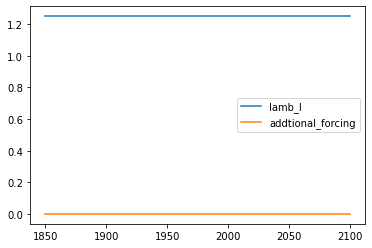

In [62]:
# 进行两个相关的绘制
plt.plot(time,lamb_l,label = 'lamb_l')
plt.plot(time,additional_forcing_l,label = 'addtional_forcing')
plt.legend()

#### tau 参数结果

(0.0, 25.0)

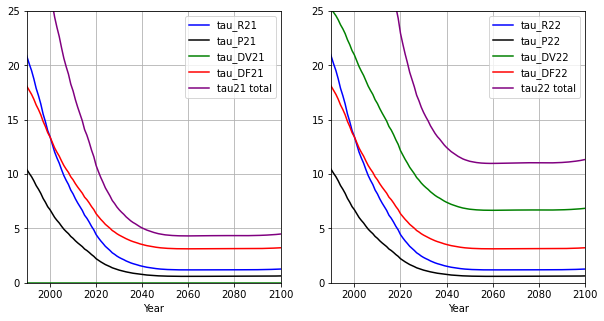

In [63]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))


ax1.plot(time, taoR21, 'blue', label='tau_R21')
ax1.plot(time, taoP21, 'black', label='tau_P21')
ax1.plot(time, taoDV21, 'green', label='tau_DV21')
ax1.plot(time, taoDF21, 'red', label='tau_DF21')
ax1.plot(time, tao21, 'purple', label='tau21 total')
ax1.set_xlabel('Year')
ax1.legend()
ax1.grid()
ax1.set_xlim((1990,2100))
ax1.set_ylim((0,25))
ax2.plot(time, taoR22, 'blue', label='tau_R22')
ax2.plot(time, taoP22, 'black', label='tau_P22')
ax2.plot(time, taoDV22, 'green', label='tau_DV22')
ax2.plot(time, taoDF22, 'red', label='tau_DF22')
ax2.plot(time, tao22, 'purple', label='tau22 total')
ax2.set_xlabel('Year')
ax2.legend()
ax2.grid()
ax2.set_xlim((1990,2100))
ax2.set_ylim((0,25))



#### Start up 

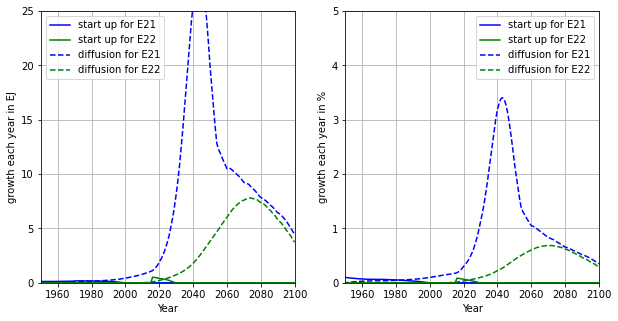

In [64]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.plot(time, (eta21), 'blue', label='start up for E21')
ax1.plot(time, (eta22), 'green', label='start up for E22')
ax1.plot(time, [(1-a/b)*a/c for a,b,c in zip(E21,k21, tao21)]  , 'blue' ,linestyle = 'dashed', label='diffusion for E21') #((1-E21/k21[-1])*E21/tao21[-1])
ax1.plot(time, [(1-a/b)*a/c for a,b,c in zip(E22,k22, tao22)]  , 'green' ,linestyle = 'dashed', label='diffusion for E22') #((1-E21/k21[-1])*E21/tao21[-1])

ax1.set_xlabel('Year')
ax1.legend()
ax1.grid()
ax1.set_xlim((1950,2100))
ax1.set_ylim((0,25))
ax1.set_ylabel('growth each year in EJ')
ax1.set_yscale('linear')

ax2.plot(time, [a/b*100 for a,b in zip(eta21,energy_MYadjusted18502100_total_plus_B3B)], 'blue', label='start up for E21')
ax2.plot(time, [a/b*100 for a,b in zip(eta22,energy_MYadjusted18502100_total_plus_B3B)], 'green', label='start up for E22')
ax2.plot(time, [(1-a/b)*a/c/d*100 for a,b,c,d in zip(E21,k21, tao21, energy_MYadjusted18502100_total_plus_B3B)]  , 'blue' ,linestyle = 'dashed', label='diffusion for E21') #((1-E21/k21[-1])*E21/tao21[-1])
ax2.plot(time, [(1-a/b)*a/c/d*100 for a,b,c,d in zip(E22,k22, tao22, energy_MYadjusted18502100_total_plus_B3B)]  , 'green' ,linestyle = 'dashed', label='diffusion for E22') #((1-E21/k21[-1])*E21/tao21[-1])

ax2.set_xlabel('Year')
ax2.legend()
ax2.grid()
ax2.set_xlim((1950,2100))
ax2.set_ylim((0,5))
ax2.set_ylabel('growth each year in %')
ax2.set_yscale('linear')


Text(0, 0.5, 'E22 capacity (EJ/year)')

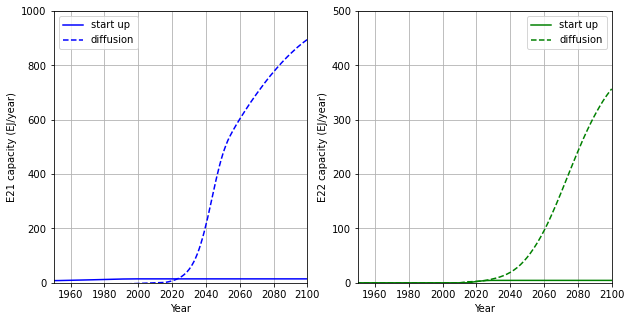

In [65]:
# 统计的相关显示内容对应
# 我猜测可能是模型运行结果的结果都储存在一个大的表格中进行显示
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.plot(time, np.cumsum(eta21)-np.cumsum(eta21)[1850-1850],'blue', linestyle = 'solid', label='start up')
ax1.plot(time, E21-E21[1850-1850]-(np.cumsum(eta21)-np.cumsum(eta21)[1850-1850]), 'blue',linestyle = 'dashed', label='diffusion')
#ax1.plot(time, E21-E21[1850-1850], 'blue',linestyle = 'solid', label='total')
ax1.set_xlabel('Year')
ax1.legend()
ax1.grid()
ax1.set_xlim((1950,2100))
ax1.set_ylim((0,1000))
ax1.set_ylabel('E21 capacity (EJ/year)')

ax2.plot(time, np.cumsum(eta22)-np.cumsum(eta22)[1850-1850],'green',linestyle = 'solid', label='start up')
ax2.plot(time, E22-E22[1850-1850]-(np.cumsum(eta22)-np.cumsum(eta22)[1850-1850]), 'green',linestyle = 'dashed', label='diffusion')
#ax2.plot(time, E22-E22[1850-1850], 'green',linestyle = 'solid', label='total')
ax2.set_xlabel('Year')
ax2.legend()
ax2.grid()
ax2.set_xlim((1950,2100))
ax2.set_ylim((0,500))
ax2.set_ylabel('E22 capacity (EJ/year)')


In [66]:
# TODO 需要进行相关的解释
output1 = pd.DataFrame([np.cumsum(eta21)-np.cumsum(eta21)[1850-1850], E21-E21[1850-1850]-(np.cumsum(eta21)-np.cumsum(eta21)[1850-1850]),np.cumsum(eta22)-np.cumsum(eta22)[1850-1850], E22-E22[1850-1850]-(np.cumsum(eta22)-np.cumsum(eta22)[1850-1850])])
output1.columns = time
#output1.to_csv('FigS10-case3.csv')#,sheet_name='3a' ) # change this filename you run the model



In [67]:
output = pd.DataFrame([taoR21,taoP21,taoDV21,taoDF21,tao21,taoR22,taoP22,taoDV22,taoDF22, tao22],index = ['taoR21','taoP21','taoDV21','taoDF21','tao21','taoR22','taoP22','taoDV22','taoDF22', 'tao22'])
output.columns = time
#output.to_csv('taovalue.csv')

(2000.0, 2100.0)

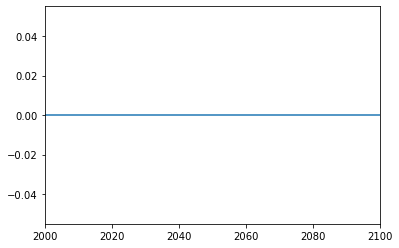

In [68]:
plt.plot(time,energy_addl_B3B_EnhanceRatio)
plt.xlim((2000,2100))


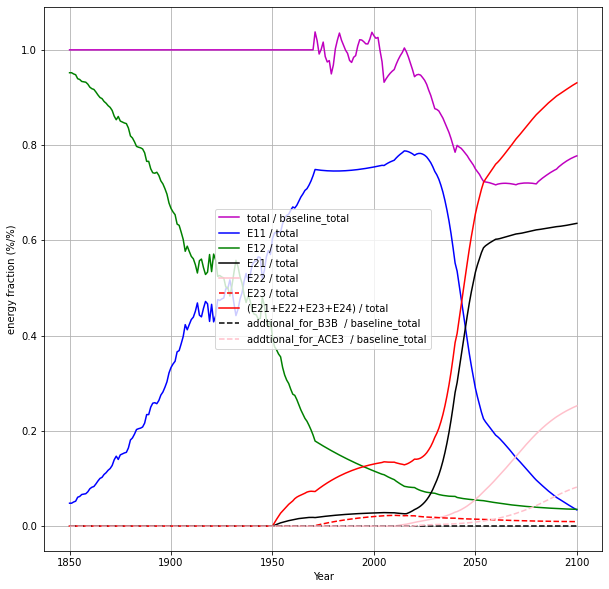

In [69]:
fig, ( ax1) = plt.subplots(1,1,figsize=(10,10))


# plot energy in relative sense

ax1.plot(time, energy_MYadjusted18502100_total_plus_B3B_plus_ACE3/energy_MYbaseline18502100_total,label = 'total / baseline_total',color = 'm',linestyle='solid')
#ax1.plot(time, [a/b for a,b in zip(energy_MYadjusted18502100_total_plus_B3B, energy_MYadjusted18502100_total)],label = 'total / adjusted_total',color = 'm',linestyle='dashed')
#ax1.plot(time, energy_MYadjusted18502100_total/energy_MYbaseline18502100_total,label = 'adjusted_total / baseline_total',color = 'm',linestyle='dotted')
ax1.plot(time, E11/energy_MYadjusted18502100_total_plus_B3B_plus_ACE3,label = 'E11 / total',color = 'blue')
ax1.plot(time, E12/energy_MYadjusted18502100_total_plus_B3B_plus_ACE3,label = 'E12 / total',color = 'green')
ax1.plot(time, E21/energy_MYadjusted18502100_total_plus_B3B_plus_ACE3,label = 'E21 / total',color = 'black')
ax1.plot(time, E22/energy_MYadjusted18502100_total_plus_B3B_plus_ACE3,label = 'E22 / total',color = 'pink')
ax1.plot(time, E23/energy_MYadjusted18502100_total_plus_B3B_plus_ACE3,label = 'E23 / total',color = 'red',linestyle = 'dashed')
ax1.plot(time, (E21+E22+E23+E24)/energy_MYadjusted18502100_total_plus_B3B_plus_ACE3,label = '(E21+E22+E23+E24) / total',color = 'red')

ax1.plot(time, energy_addl_B3B_EnhanceRatio,linestyle='dashed',label = 'addtional_for_B3B  / baseline_total',color = 'black')
ax1.plot(time, [a/b*44/12*10 for a,b in zip(CO2emission_ACE3,energy_MYbaseline18502100_total)] ,linestyle='dashed',label = 'addtional_for_ACE3  / baseline_total',color = 'pink')

ax1.grid()
ax1.set_xlabel('Year')
ax1.set_ylabel('energy fraction (%/%)')
ax1.legend()


(0.0, 1800.0)

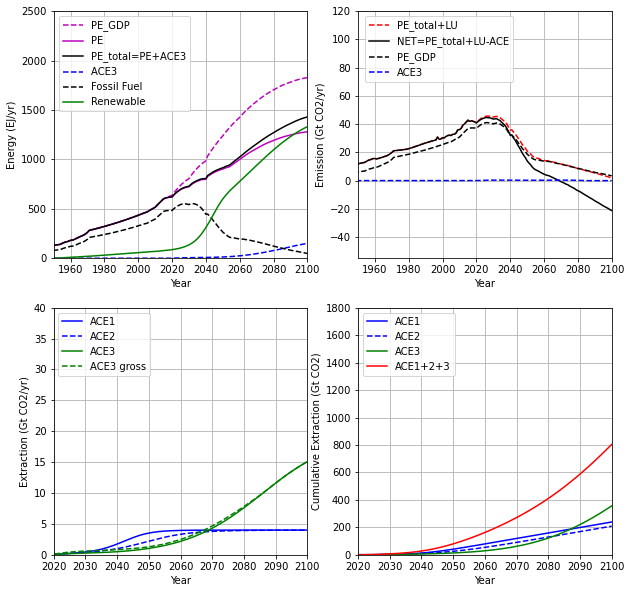

In [70]:
fig, ( [ax2, ax3], [ax4, ax5]) = plt.subplots(2,2,figsize=(10,10))

# plot energy in abs sense

ax2.plot(time, energy_MYbaseline18502100_total_formulated,label = 'PE_GDP',color = 'm',linestyle='dashed')
ax2.plot(time, energy_MYadjusted18502100_total,label = 'PE',color = 'm',linestyle='solid')
#ax2.plot(time, energy_MYadjusted18502100_total_plus_B3B,label = 'adj. GE+B3B',color = 'black',linestyle='solid')

#ax2.plot(time, [a+x*44/12/y*10 for a,x,y in zip(energy_MYadjusted18502100_total_plus_B3B, CO2emission_ACE3,ratio_net_over_gross)] ,linestyle='solid',label = 'NET=adj. GE+B3B+ACE3 ',color = 'black')
ax2.plot(time, energy_MYadjusted18502100_total_plus_B3B_plus_ACE3,label = 'PE_total=PE+ACE3', linestyle='solid',color = 'black')


#ax2.plot(time, E22,label = 'E22',color = 'green')
#ax2.plot(time, E23+E24,label = 'E23+E24',color = 'red',linestyle = 'dashed')
#ax2.plot(time, E24,label = 'E24',color = 'black')
#ax2.plot(time, [a-b for a,b in zip(energy_MYadjusted18502100_total_plus_B3B,energy_MYadjusted18502100_total)] ,label = 'B3B',linestyle='dotted',color = 'black')

#ax2.plot(time, [x*44/12/y*10 for x,y in zip(CO2emission_ACE3,ratio_net_over_gross)] ,linestyle='dashed',label = 'ACE3 ',color = 'blue')
ax2.plot(time, [a-b for a,b in zip(energy_MYadjusted18502100_total_plus_B3B_plus_ACE3,energy_MYadjusted18502100_total_plus_B3B)] ,label = 'ACE3 ',linestyle='dashed',color = 'blue')

ax2.plot(time, E11,label = 'Fossil Fuel',color = 'black',linestyle = 'dashed')
#ax2.plot(time, E12,label = 'E12',color = 'green')
ax2.plot(time, E21+E22+E23+E24,label = 'Renewable',color = 'green',linestyle = 'solid')


ax2.grid()
ax2.set_xlabel('Year')
ax2.set_ylabel('Energy (EJ/yr)')
ax2.legend()

### plot emission

ax3.plot(time, [x*44/12 for x in CO2emission_actual],        label = 'PE_total+LU',color = 'red',linestyle='dashed')
ax3.plot(time, [(a-b-c-d/e)*44/12 for a,b,c,d,e in zip(CO2emission_actual,CO2emission_ACE1,CO2emission_ACE2,CO2emission_ACE3, ratio_net_over_gross)],        label = 'NET=PE_total+LU-ACE',color = 'black',linestyle = 'solid')
#ax3.plot(time, [(a+b+c+d)*44/12 for a,b,c,d in zip (CO2emission_GE_FF,CO2emission_baseline18502100_LU,CO2emission_addl_B3B_FF_injustice,CO2emission_addl_ACE3_FF_injustice )],        label = 'GE+LU+B3B+ACE3',color = 'red',linestyle='dashed')

ax3.plot(time, [x*44/12 for x in CO2emission_GE_FF] ,      label = 'PE_GDP',color = 'black',linestyle = 'dashed')
#ax3.plot(time, [x*44/12 for x in CO2emission_baseline18502100_LU],                     label = 'LU (not E12)',color = 'green',linestyle = 'dashed')
#ax3.plot(time, [x*44/12 for x in CO2emission_addl_B3B_FF_injustice],      label = 'B3B',color = 'black',linestyle = 'dotted')
#ax3.plot(time, [x*44/12 for x in CO2emission_addl_B3B_FF],      label = 'B3B',color = 'black',linestyle = 'dotted')
ax3.plot(time, [x*44/12 for x in CO2emission_addl_ACE3_FF_injustice],      label = 'ACE3',color = 'blue',linestyle = 'dashed')


ax3.grid()
ax3.set_xlabel('Year')
ax3.set_ylabel('Emission (Gt CO2/yr)')
ax3.legend(bbox_to_anchor=(0.63,1.0))

### plot ACE
ax4.plot(time, [x*44/12 for x in CO2emission_ACE1],                     label = 'ACE1',color = 'blue')
ax4.plot(time, [x*44/12 for x in CO2emission_ACE2],                     label = 'ACE2',color = 'blue',linestyle = 'dashed')
ax4.plot(time, [x*44/12 for x in CO2emission_ACE3],                     label = 'ACE3',color = 'green')
ax4.plot(time, [x/y*44/12 for x,y in zip(CO2emission_ACE3,ratio_net_over_gross)],                     label = 'ACE3 gross',color = 'green',linestyle = 'dashed')
#ax4.plot(time, ratio_net_over_gross,                     label = 'ratio',color = 'green',linestyle = 'dashed')

#ax4.plot(time, [(a+b+c)*44/12 for a,b,c in zip(CO2emission_ACE1,CO2emission_ACE2,CO2emission_ACE3)],                     label = 'ACE1+2+3',color = 'red',linestyle = 'dashed')

ax4.grid()
ax4.legend(bbox_to_anchor=(0.4,1.0))
ax4.set_xlabel('Year')
ax4.set_ylabel('Extraction (Gt CO2/yr)')


### plot ACE
ax5.plot(time, np.cumsum(CO2emission_ACE1)*44/12,                     label = 'ACE1',color = 'blue')
ax5.plot(time, np.cumsum(CO2emission_ACE2)*44/12,                     label = 'ACE2',color = 'blue',linestyle = 'dashed')
ax5.plot(time, np.cumsum(CO2emission_ACE3)*44/12,                     label = 'ACE3',color = 'green')
ax5.plot(time, [a+b+c for a,b,c in zip(np.cumsum(CO2emission_ACE1)*44/12,np.cumsum(CO2emission_ACE2)*44/12,np.cumsum(CO2emission_ACE3)*44/12)],                     label = 'ACE1+2+3',color = 'red',linestyle = 'solid')

ax5.grid()
ax5.legend(bbox_to_anchor=(0.4,1.0))
ax5.set_xlabel('Year')
ax5.set_ylabel('Cumulative Extraction (Gt CO2)')
#ax5.set_ylim([-30, 130])




#set limit for x axis
ax2.set_xlim([1950, 2100])
ax3.set_xlim([1950, 2100])
ax4.set_xlim([2020, 2100])
ax5.set_xlim([2020, 2100])

ax2.set_ylim([0, 2500])
ax3.set_ylim([-55, 120])
ax4.set_ylim([0, 40])
ax5.set_ylim([0, 1800])

#plt.savefig('fig4cd.pdf')


1042.0077919528844


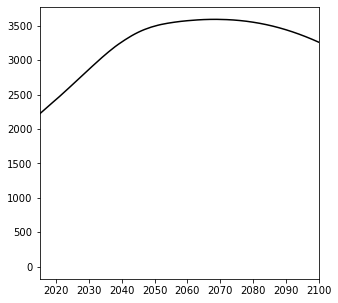

In [71]:
fig, ( ax) = plt.subplots(1,1,figsize=(5,5))
ax.plot(time, np.cumsum([(a-b-c-d/e)*44/12 for a,b,c,d,e in zip(CO2emission_actual,CO2emission_ACE1,CO2emission_ACE2,CO2emission_ACE3, ratio_net_over_gross)]),        label = 'NET=PE_total+LU-ACE',color = 'black',linestyle = 'solid')
#ax.set_ylim([-40, 60])
ax.set_xlim([2015, 2100])
print(np.cumsum([(a-b-c-d/e)*44/12 for a,b,c,d,e in zip(CO2emission_actual,CO2emission_ACE1,CO2emission_ACE2,CO2emission_ACE3, ratio_net_over_gross)])[-1]-np.cumsum([(a-b-c-d/e)*44/12 for a,b,c,d,e in zip(CO2emission_actual,CO2emission_ACE1,CO2emission_ACE2,CO2emission_ACE3, ratio_net_over_gross)])[-1-(2100-2015)])

In [72]:
output = pd.DataFrame([energy_MYbaseline18502100_total, energy_MYadjusted18502100_total, energy_MYadjusted18502100_total_plus_B3B_plus_ACE3, [a-b for a,b in zip(energy_MYadjusted18502100_total_plus_B3B,energy_MYadjusted18502100_total)], [a-b for a,b in zip(energy_MYadjusted18502100_total_plus_B3B_plus_ACE3,energy_MYadjusted18502100_total_plus_B3B)], E11, E21+E22+E23+E24]) 
output.columns = time
#output.to_csv('Fig4c.csv')#,sheet_name='3a' ) # change this filename you run the model

output = pd.DataFrame([[x*44/12 for x in CO2emission_actual], [(a-b-c-d/e)*44/12 for a,b,c,d,e in zip(CO2emission_actual,CO2emission_ACE1,CO2emission_ACE2,CO2emission_ACE3, ratio_net_over_gross)], [x*44/12 for x in CO2emission_GE_FF], [x*44/12 for x in CO2emission_addl_B3B_FF_injustice], [x*44/12 for x in CO2emission_addl_ACE3_FF_injustice]]) 
output.columns = time
#output.to_csv('Fig4d.csv')#,sheet_name='3a' ) # change this filename you run the model



#### 比较实际的 Co2 和模拟的 Co2
- CO2emission_actualFF 模拟值
- CO2emission_baseline18502100_FF 真实值


(0.0, 40.0)

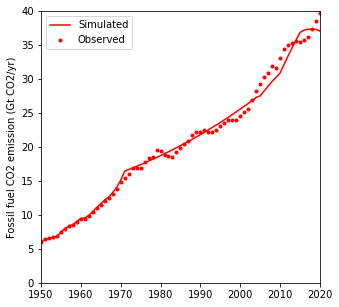

In [73]:
# compare CO2 emission for hist

plt.figure(figsize = (5,5))
plt.plot(time, [x*44/12 for x in CO2emission_actualFF], label = 'Simulated',color = 'red')
plt.plot(time, [x*44/12 for x in CO2emission_baseline18502100_FF] , label = 'Observed',linestyle='', marker='.',color = 'red')
plt.ylabel('Fossil fuel CO2 emission (Gt CO2/yr)')
plt.legend() 
plt.xlim([1950, 2020])
plt.ylim([0, 40])

#plt.savefig('fig2b.pdf')


### IAM(原来的模型) 和我们的 ISEEC 模型结果对比

IAM_CO2emission = pd.read_excel('../data/input/IAM_for_comparision_june2021.xlsx',sheet_name = 'CO2emission')

(-20.0, 5.0)

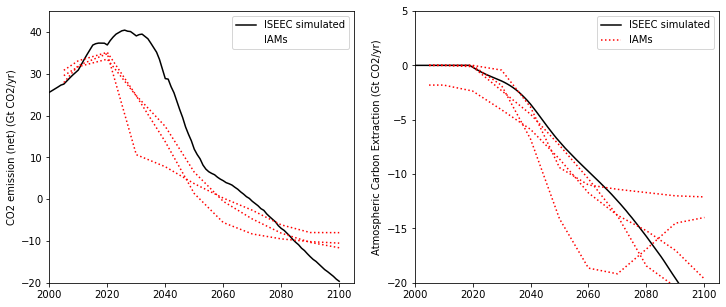

In [74]:
# added in June 2021

# compare CO2 emission for hist

IAM_CO2emission = pd.read_excel('../data/input/IAM_for_comparision_june2021.xlsx',sheet_name = 'CO2emission')
#print(IAM_CO2emission.iloc[5,3:13].astype('float'))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
## C_a needs to *rho_a to convert Gt to ppm


ax1.plot(time, [(x-b-c-d/e)*44/12 for x,b,c,d,e in zip(CO2emission_actualFF,CO2emission_ACE1,CO2emission_ACE2,CO2emission_ACE3, ratio_net_over_gross)],  label = 'ISEEC simulated',color = 'black',linestyle = 'solid')
ax1.plot( IAM_CO2emission.iloc[10-2,4:].astype('float')/1e3-IAM_CO2emission.iloc[6-2,4:].astype('float')/1e3 , label = 'IAMs',linestyle='', marker='',color = 'red')  # the 7th role is actual FF
ax1.plot( IAM_CO2emission.iloc[11-2,4:].astype('float')/1e3-IAM_CO2emission.iloc[7-2,4:].astype('float')/1e3, linestyle='dotted', marker='',color = 'red')  # the 7th role is actual FF
ax1.plot( IAM_CO2emission.iloc[12-2,4:].astype('float')/1e3-IAM_CO2emission.iloc[8-2,4:].astype('float')/1e3 , linestyle='dotted', marker='',color = 'red')  # the 7th role is actual FF
ax1.plot( IAM_CO2emission.iloc[13-2,4:].astype('float')/1e3-IAM_CO2emission.iloc[9-2,4:].astype('float')/1e3 , linestyle='dotted', marker='',color = 'red')  # the 7th role is actual FF

ax1.set_ylabel('CO2 emission (net) (Gt CO2/yr)')
ax1.set_xlim([2000, 2105])
ax1.set_ylim([-20, 45])
ax1.legend()

### plot emission

ax2.plot(time, [-(b+c+d/e)*44/12 for b,c,d,e in zip(CO2emission_ACE1,CO2emission_ACE2,CO2emission_ACE3, ratio_net_over_gross)],  label = 'ISEEC simulated',color = 'black',linestyle = 'solid')
ax2.plot( -IAM_CO2emission.iloc[6-2,4:].astype('float')/1e3 , label = 'IAMs',linestyle='dotted', marker='',color = 'red')  # the 7th role is actual FF
ax2.plot( -IAM_CO2emission.iloc[7-2,4:].astype('float')/1e3 , linestyle='dotted', marker='',color = 'red')  # the 7th role is actual FF
ax2.plot( -IAM_CO2emission.iloc[8-2,4:].astype('float')/1e3 , linestyle='dotted', marker='',color = 'red')  # the 7th role is actual FF
ax2.plot( -IAM_CO2emission.iloc[9-2,4:].astype('float')/1e3 , linestyle='dotted', marker='',color = 'red')  # the 7th role is actual FF

ax2.legend()

ax2.set_ylabel('Atmospheric Carbon Extraction (Gt CO2/yr)')
ax2.set_xlim([2000, 2105])
ax2.set_ylim([-20, 5])

#plt.savefig('fig3ab.pdf')


In [75]:
output = pd.DataFrame([[x*44/12 for x in CO2emission_actualFF], [x*44/12 for x in CO2emission_baseline18502100_FF]]) 
output.columns = time
#output.to_csv('Fig3b.csv')#,sheet_name='3a' ) # change this filename you run the model


# 读取外部数据(csv文件获取)

#### 读 OBS TEMP

In [76]:
# read obs temp

temp = pd.read_csv('../data/input/GLB.Ts+dSST.xlsx')
#only extract year 1850-2018 from the original table
diff = T_a[:141].mean() - temp.iloc[1:-29,13].astype('float').mean()
#print(temp)


CO2 = pd.read_excel('../data/input/spline_merged_ice_core_yearly.xlsx',sheet_name = 'Sheet1')


#### 读 CESM temp

In [77]:
# read CESM temp  # added in June 2021

temp_cesm = pd.read_excel('../data/input/CESM1-LENS_GMST_1920-2080.xlsx')

temp_cesm_GMST=temp_cesm.iloc[:,2].astype('float')
temp_cesm_year=temp_cesm.iloc[:,0].astype('float')

#only extract year 1850-2018 from the original table
#diff = T_a[:141].mean() - temp_cesm.iloc[1:-29,13].astype('float').mean()

401.3738133642822
1.8393499972068812


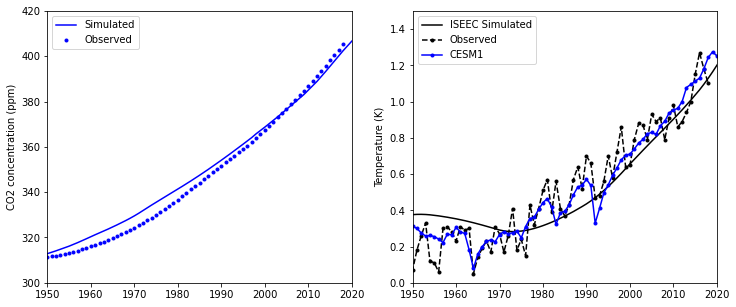

In [78]:
# just for hist

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
## C_a needs to *rho_a to convert Gt to ppm

ax1.plot(time, C_a*rho_a, color ='blue', label='Simulated')
ax1.set_ylabel('CO2 concentration (ppm)')
#ax1.set_xlabel('Year')
ax1.plot(CO2.year,CO2.co2,linestyle='', marker='.',color ='blue',label='Observed')
#ax1.grid()
ax1.set_xlim((1950,2020))
ax1.set_ylim((300,420))

#temperature of atomosphere for 4 cases
ax2.plot(time, T_a, 'black', label='ISEEC Simulated')
ax2.plot(temp.iloc[1:-1,0].astype('int'),temp.iloc[1:-1,13].astype('float') +0.25  ,linestyle='--', marker='.',color ='black',label = 'Observed') # + diff
ax2.plot(temp_cesm_year,temp_cesm_GMST -286.05  ,linestyle='-', marker='.',color ='blue',label = 'CESM1') # + diff



#ax2.set_xlabel('Year')
ax2.set_ylabel('Temperature (K)')
#ax2.grid()
ax2.set_xlim((1950,2020))
ax2.set_ylim((-0.0,1.5))


print(C_a[-1]*rho_a)
print(T_a[-1])
ax1.legend()
ax2.legend()

plt.savefig('fig2cd_new_Nov17.pdf')


401.3738133642822
1.8393499972068812


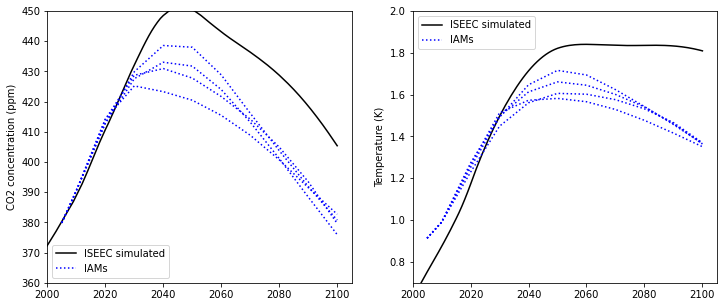

In [79]:
# added June 2021 for future comparsiion

IAM_CO2concentration = pd.read_excel('../data/input/IAM_for_comparision_june2021.xlsx',sheet_name = 'CO2concentration')
IAM_Temperature = pd.read_excel('../data/input/IAM_for_comparision_june2021.xlsx',sheet_name = 'Temperature')


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

ax1.plot(time, C_a*rho_a*1.01, color ='black', label='ISEEC simulated') ## C_a needs to *rho_a to convert Gt to ppm
ax1.plot( IAM_CO2concentration.iloc[2-2,4:].astype('float') , label = 'IAMs',linestyle='dotted', marker='',color = 'blue')  # the 7th role is actual FF
ax1.plot( IAM_CO2concentration.iloc[3-2,4:].astype('float') , linestyle='dotted', marker='',color = 'blue')  # the 7th role is actual FF
ax1.plot( IAM_CO2concentration.iloc[4-2,4:].astype('float') , linestyle='dotted', marker='',color = 'blue')  # the 7th role is actual FF
ax1.plot( IAM_CO2concentration.iloc[5-2,4:].astype('float') , linestyle='dotted', marker='',color = 'blue')  # the 7th role is actual FF

#ax1.grid()
#ax1.set_xlabel('Year')
ax1.set_ylabel('CO2 concentration (ppm)')
ax1.set_xlim((2000,2105))
ax1.set_ylim((360,450))

#temperature of atomosphere for 4 cases
ax2.plot(time, T_a-0.03, 'black', label='ISEEC simulated')
ax2.plot( IAM_Temperature.iloc[2-2,4:].astype('float') , label = 'IAMs',linestyle='dotted', marker='',color = 'blue')  # the 7th role is actual FF
ax2.plot( IAM_Temperature.iloc[3-2,4:].astype('float') ,linestyle='dotted', marker='',color = 'blue')  # the 7th role is actual FF
ax2.plot( IAM_Temperature.iloc[4-2,4:].astype('float') , linestyle='dotted', marker='',color = 'blue')  # the 7th role is actual FF
ax2.plot( IAM_Temperature.iloc[5-2,4:].astype('float') , linestyle='dotted', marker='',color = 'blue')  # the 7th role is actual FF

#ax2.set_xlabel('Year')
ax2.set_ylabel('Temperature (K)')
#ax2.grid()
ax2.set_xlim((2000,2105))
ax2.set_ylim((0.7,2))


print(C_a[-1]*rho_a)
print(T_a[-1])
ax1.legend()
ax2.legend()

#plt.savefig('fig3cd.pdf')


In [80]:
output = pd.DataFrame([C_a*rho_a, CO2.co2]) 
output.columns = time
#output.to_csv('Fig3c.csv')#,sheet_name='3a' ) # change this filename you run the model


output = pd.DataFrame([T_a, temp.iloc[1:-1,13].astype('float') +0.3 ]) 
output.columns = time
#output.to_csv('Fig3d.csv')#,sheet_name='3a' ) # change this filename you run the model


401.3738133642822
1.8393499972068812
-0.023471497098826788


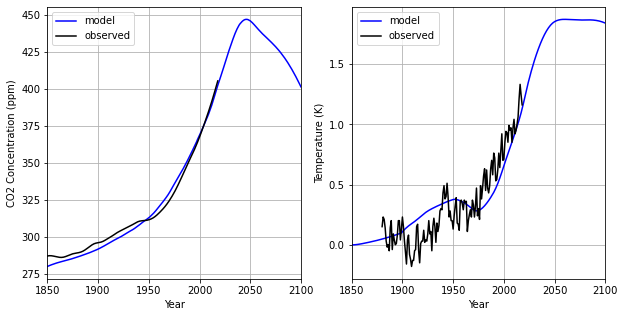

In [81]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
## C_a needs to *rho_a to convert Gt to ppm

ax1.plot(time, C_a*rho_a, 'blue', label='model')
ax1.set_ylabel('CO2 Concentration (ppm)')
ax1.set_xlabel('Year')
ax1.plot(CO2.year,CO2.co2,'black',label='observed')
ax1.grid()
ax1.set_xlim((1850,2100))
#ax1.set_ylim((300,800))
#temperature of atomosphere for 4 cases
ax2.plot(time, T_a, 'blue', label='model')
ax2.plot(temp.iloc[1:-1,0].astype('int'),temp.iloc[1:-1,13].astype('float') + diff ,'black',label = 'observed')
ax2.set_xlabel('Year')
ax2.set_ylabel('Temperature (K)')
ax2.grid()
ax2.set_xlim((1850,2100))
#ax2.set_ylim((-0.2,2.0))
print(C_a[-1]*rho_a)
print(T_a[-1])
print(T_a[-1]-T_a[-11])
ax1.legend()
ax2.legend()

#### 套路化的绘制相关的图

In [82]:
# 竟然使用到了 MAtlab

## the rest is for outputing indiviudal cases into csv, before putting them together in matlab

output = pd.DataFrame([ CO2emission_actual,CO2emission_ACE1,CO2emission_ACE2,[a/b for a,b in zip(CO2emission_ACE3,ratio_net_over_gross)], C_a*rho_a, T_a, energy_MYadjusted18502100_total_plus_B3B_plus_ACE3,E21+E22+E23+E24, E21+E22]) #,index = ['T_a','C_a*rho_a','gross emission in GtC','ACE1 in GtC','ACE2 in GtC','ACE3 in GtC']
output.columns = time
output.to_csv('Fig5v3_case9.csv') # change this filename you run the model

In [83]:
# the rest are reading population , GDP and energy data from external sources
# 叠加相关的数据进行比较
# later I need to overlay my data on top of those to compare the model with those external sources

我猜下面应该是从官网下载的相关数据

关键注意查看其中的读入数据来源部分：

P_P_Scenarios = pd.read_excel('../data/input/PopulationGDP_9.12.19.xlsx',sheet_name= 'Population Projection Scenarios')

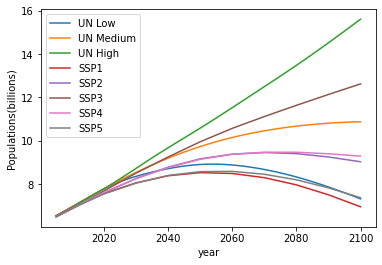

In [84]:
P_P_Scenarios = pd.read_excel('../data/input/PopulationGDP_9.12.19.xlsx',sheet_name= 'Population Projection Scenarios')

for i in range(1,9):
    plt.plot(P_P_Scenarios.iloc[:,0],P_P_Scenarios.iloc[:,i],label = '{}'.format(P_P_Scenarios.columns[i]))
plt.xlabel('year')
plt.ylabel('Populations(billions)')
plt.legend()

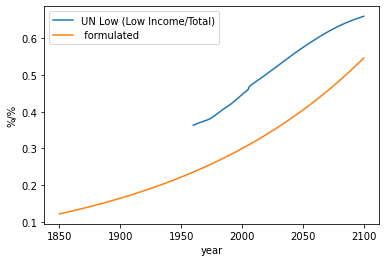

In [85]:
Low_income = pd.read_excel('../data/input//PopulationGDP_9.12.19.xlsx',sheet_name= 'Low Income Pop. Proj. Scenarios')

plt.plot(Low_income.iloc[:,0],Low_income.iloc[:,4],label = '{}'.format(Low_income.columns[4]))
Nb_over_NT= 0.33*np.exp(0.15*(time-2016)/25)
plt.plot(time,Nb_over_NT, label = ' formulated')
plt.xlabel('year')
plt.ylabel('%/%')
plt.legend()



In [86]:
# 进行相关的比较

# the following are comparing the energy from external sources vs. energy simulated by the model

energy = pd.read_excel('../data/input/energy_data11.12_TV.xlsx',sheet_name= '1971-2015 World Bank Data')
pop = pd.read_excel('../data/input/PopulationGDP_9.12.19.xlsx',sheet_name= 'Data')


Text(0, 0.5, 'IEA via World Bank energy data (billions kg oil eq)')

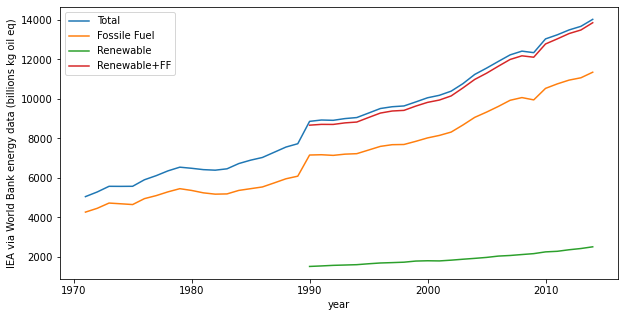

In [87]:
plt.figure(figsize=(10,5))
plt.plot(energy.iloc[15,13:-1].index.astype('int'),energy.iloc[15,13:-1].values * pop.iloc[12:56,1] ,label = 'Total  ')
plt.plot(energy.iloc[16,13:-1].index.astype('int'),energy.iloc[16,13:-1].values * pop.iloc[12:56,1] ,label = 'Fossile Fuel ')
plt.plot(energy.iloc[17,13:-1].index.astype('int'),energy.iloc[17,13:-1].values * pop.iloc[12:56,1],label = 'Renewable  ')
plt.plot(energy.iloc[17,13:-1].index.astype('int'),energy.iloc[17,13:-1].values * pop.iloc[12:56,1]+energy.iloc[16,13:-1].values * pop.iloc[12:56,1],label = 'Renewable+FF')
plt.legend()
plt.xlabel('year')
plt.ylabel('IEA via World Bank energy data (billions kg oil eq)')

可能是大概得对比，不一定有那么准备，但是是不断改善的过程

0.04153282402762044
0.040208351861541286


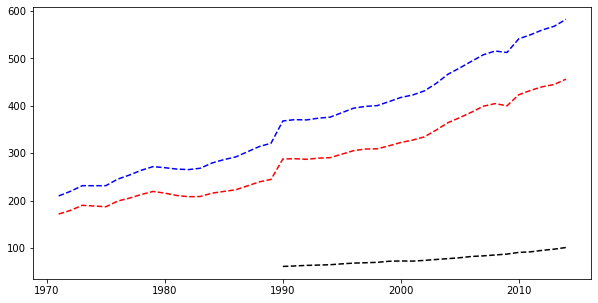

In [88]:
# unit conversion

pop_long = pop.iloc[12:56,1]
pop_short = pop.iloc[31:56,1]

total_energy = energy.iloc[15,13:-1] 
FF_energy = energy.iloc[16,13:-1] 
renew_energy = energy.iloc[17,32:-1] 

#energy_data0930/future data/f6   387.4 -> 2005 FF
# /1971-2015 World Bank Data 1,425.817  -> 2005 FF
#population 6.541907 billion

energy_pop = 6.541907 * 1425.817
mult = 387.4 / energy_pop
# converstion based on FF; to go from kg oil eq to EJ

energy_pop2 = 6.541907 * 1766.276
mult2 = 464.600 / energy_pop2
# converstion based on total; to go from kg oil eq to EJ

print(mult)
print(mult2)
# these two are similar anyway

plt.figure(figsize=(10,5))

plt.plot(total_energy.index.astype('int'),total_energy.values*pop_long*mult,label = 'IEA Total', linestyle='dashed',color = 'b')
plt.plot(FF_energy.index.astype('int'),FF_energy.values*pop_long*mult2,label = 'IEA FF', linestyle='dashed',color = 'r')
plt.plot(renew_energy.index.astype('int'),renew_energy.values*pop_short*mult2,label = 'IEA Renewable', linestyle='dashed',color = 'black')


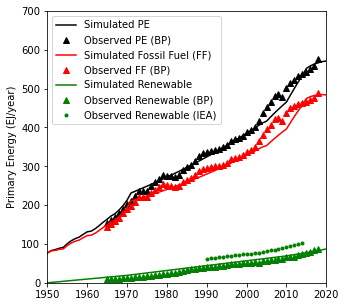

In [89]:
# 连续进行相关的比较



Comp = pd.read_excel('../data/input/energy_data11.12_TV.xlsx',sheet_name= 'Comparison')
Comp = Comp.set_index(Comp['Year'])

#print(Comp)
plt.figure(figsize = (5,5))

plt.plot(time,E11+E21+E22+E23+E24,label = 'Simulated PE',    linestyle='solid',color = 'black')
plt.plot(Comp.iloc[:,1]*mult, linestyle='', marker='^',color = 'black',label = 'Observed PE (BP)') #', 
#plt.plot(Comp.iloc[:,2]*mult, linestyle='', marker='.',color = 'black',label = 'Observed Total (IEA)') #'

plt.plot(time,E11,label = 'Simulated Fossil Fuel (FF)', linestyle='solid',color = 'red')
plt.plot(Comp.iloc[:,3]*mult, linestyle='', marker='^',color = 'red',label = 'Observed FF (BP)') #
#plt.plot(Comp.iloc[:,4]*mult, linestyle='', marker='.',color = 'red',label = 'Observed FF (IEA)') #'

plt.plot(time,E21+E22+E23+E24,label = 'Simulated Renewable', linestyle='solid',color = 'green')
plt.plot(Comp.iloc[:,5]*mult, linestyle='', marker='^',color = 'green',label = 'Observed Renewable (BP)') #,
plt.plot(Comp.iloc[:,6]*mult, linestyle='', marker='.',color = 'green',label = 'Observed Renewable (IEA)') #

#plt.plot(time,E21,label = 'E21', linestyle='solid',color = 'green')


plt.ylabel('Primary Energy (EJ/year)')
plt.legend()

plt.xlim([1950,2020])
plt.ylim([0,700])

plt.savefig('fig2a.pdf')


In [90]:
output = pd.DataFrame([energy_MYbaseline18502100_total,E11, Comp.iloc[:,4]*mult,E21+E22+E23+E24, Comp.iloc[:,5]*mult, Comp.iloc[:,6]*mult  ]) #,index = ['T_a','C_a*rho_a','gross emission in GtC','ACE1 in GtC','ACE2 in GtC','ACE3 in GtC']
output.columns = time
#output.to_csv('Fig3a.csv')#,sheet_name='3a' ) # change this filename you run the model


## 添加内部的噪音往模型中

In [2]:
# the following is for including the internal noise to the model

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

result = []  # this is the variable for saving the ensemble

for i in range(10):  # you can even make the range to be 10000 to create a super ensemble
    
    amp = np.random.normal(2, 0.1, 251)#*0
    phase = np.random.uniform(0,60,1)[0]
    period = np.random.normal(5,5,26)
    
    global taoR21,taoP21,taoDV21,taoDF21,tao21,taoR22,taoP22,taoDV22,taoDF22,tao22,time_count, CO2emission_actual,  CO2emission_actualFF, CO2emission_actualbiomass, energy_MYadjusted18502100_total_plus_B3B, energy_addl_B3B_EnhanceRatio, eta21,eta22, CO2emission_addl_enhance

    taoR21 , taoP21 , taoDV21 , tao21,tao22,taoDF21 , taoR22 , taoP22 , taoDV22 , taoDF22 ,time_count, CO2emission_actual , CO2emission_actualFF, CO2emission_actualbiomass, energy_MYadjusted18502100_total_plus_B3B, energy_addl_B3B_EnhanceRatio,eta21, eta22, CO2emission_addl_enhance= [],[],[],[],[], [],[],[],[],[],[],[],[],[],[],[],[],[],[]

    global CO2emission_ACE1, CO2emission_ACE2, CO2emission_ACE3

    CO2emission_ACE1, CO2emission_ACE2, CO2emission_ACE3= [],[],[]
    
    # 基本驱动的外界参数使用 第0个数组进行相关操作 
    y0 = [0,cina,cino,cinod,0, 0, 0, 0, 0,  energy_MYbaseline18502100_biomass[0]] 
    # the initial values of T_a, C_a, C_o, C_od, T_o,.... 
    
    y = odeint(IEM,y0,time)
    
    # 每次模拟返回的一个结果就是数值的第一列
    T_a = y[:,0] #  return np.array([dT_a_dt,dC_a_dt,dC_o_dt,dC_od_dt,dT_o_dt,dE21_dt, dE22_dt, dE23_dt, dE24_dt, dE12_dt])
    
    result.append(T_a)

NameError: name 'cina' is not defined

展示其中模拟运行的结果结果

401.3738133642822
1.8536853385941017


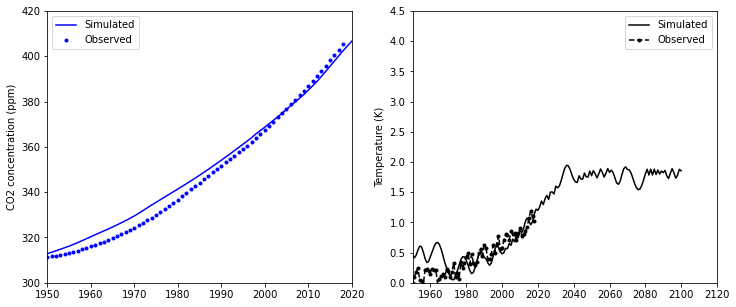

In [92]:
# just for hist, but with noise

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
## C_a needs to *rho_a to convert Gt to ppm

# 模拟运行的其中一个模块内容
ax1.plot(time, C_a*rho_a, color ='blue', label='Simulated')
ax1.set_ylabel('CO2 concentration (ppm)')
#ax1.set_xlabel('Year')

# 因为是全局变量，所以后续可以多维参数的定义调用操作
# 来自于其中的观测数据：
# CO2 = pd.read_excel('../data/input/spline_merged_ice_core_yearly.xlsx',sheet_name = 'Sheet1')

ax1.plot(CO2.year,CO2.co2,linestyle='', marker='.',color ='blue',label='Observed')
#ax1.grid()
ax1.set_xlim((1950,2020))
ax1.set_ylim((300,420))

#temperature of atomosphere for 4 cases

# 通过观测的结果展示
# temp = pd.read_csv('../data/input/GLB.Ts+dSST.xlsx')

ax2.plot(time, T_a, 'black', label='Simulated') # 
ax2.plot(temp.iloc[1:-1,0].astype('int'),temp.iloc[1:-1,13].astype('float') +0.17  ,linestyle='--', marker='.',color ='black',label = 'Observed') # + diff
#ax2.plot(temp_cesm_year,temp_cesm_GMST -286.1  ,linestyle='-', marker='.',color ='blue',label = 'CESM1 Simulated') # + diff


#ax2.set_xlabel('Year')
ax2.set_ylabel('Temperature (K)')
#ax2.grid()
ax2.set_xlim((1950,2120))
ax2.set_ylim((-0.0,4.5))


print(C_a[-1]*rho_a)
print(T_a[-1])
ax1.legend()
ax2.legend()

In [93]:

#print(result)

# output for gabby in Oct 22, 2021
output = pd.DataFrame(result) 
#output.columns = time
output.to_csv('RXMnoise.csv')#,sheet_name='3a' ) # change this filename you run the model

    

In [94]:
# 没有被用到，所以不用查看了
def max_list(b):
    result = []
    for a in range(len(b[0])):  
        result.append(max([i[a] for i in b]))
    return result

def min_list(b):
    result = []
    for a in range(len(b[0])):  
        result.append(min([i[a] for i in b]))
    return result

from statistics import median 

def median_list(b):
    result = []
    for a in range(len(b[0])):  
        result.append(median([i[a] for i in b]))
    return result

Text(0, 0.5, 'Temperature for atmo')

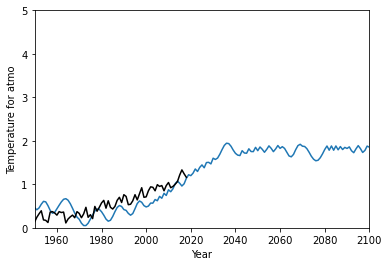

In [95]:
#plt.plot(time,max_list(result))  
#plt.plot(time,min_list(result))
#plt.plot(time,median_list(result)) 

plt.plot(time,T_a) 

plt.plot(temp.iloc[1:-1,0].astype('int'),temp.iloc[1:-1,13].astype('float') + diff ,'black',label = 'observed')

plt.xlim((1950,2100))
plt.ylim((-0.0,5))
plt.xlabel('Year')
plt.ylabel('Temperature for atmo')